# Seattle Airbnb Exploration

## Table of Contents
<ol>
    <li><a href="#intro">Introduction</a></li>
    <li><a href="#gather">Gather</a></li>
    <li><a href="#assess">Assess</a>
    <ol type="1">
        <li><a href="#calendar">Calendar</a></li>
        <li><a href="#listings">Listings</a></li>
        <li><a href="#reviews">Reviews</a></li>
    </ol></li>
    <li><a href="#business">Business Understanding</a></li>
    <li><a href="#data">Data Understanding</a>
    <ol type="1">
        <li><a href="#listing">Calendar Information</a></li>
        <li><a href="#host">Listings Information</a></li>
        <li><a href="#review">Reviews Information</a></li>
        <li><a href="#date">Date Information</a></li>
    </ol></li>
    <li><a href="#prep">Data Preparation</a>
    <ol type="1">
        <li><a href="#clean">Cleaning</a>
        <ol type="1">
            <li><a href="#zipcode">Missing zipcodes</a></li>
            <li><a href="#join">Join datasets</a></li>
            <li><a href="#unnecessary">Drop unnecessary columns</a></li>
            <li><a href="#rows">Drop specified rows with missing values</a></li>
            <li><a href="#str">Convert columns to `str`</a>
            <li><a href="#bool">Convert columns to `1`, `0`</a></li>
            <li><a href="#price">Convert price/percent columns to `float`</a></li>
            <li><a href="#datetime">Convert columns to `datetime`</a></li>
            <li><a href="#unix">Convert `host_since` to unix time</a></li>
            <li><a href="#amen">Extract amenities</a></li>
            <li><a href="#remain">Manage remaining columns</a>
        </ol></li>
        <li><a href="#engineer">Feature Engineering</a>
        <ol type="1">
            <li><a href="#balance">Balance the data</a></li>
            <li><a href="#cat">Convert categorical columns to dummies</a></li>
            <li><a href="#date-feat">Create date dummies</a></li>
            <li><a href="#split">Train-Test Split</a></li>
            <li><a href="#skew">Review distribution skew</a></li>
            <li><a href="#text">Text extraction</a></li>
            <li><a href="#missing">Explore missing values</a></li>
            <li><a href="#function">Create engineering function</a></li>
        </ol></li>
    </ol></li>
    <li><a href="#model">Modeling</a>
    <ol type="1">
        <li><a href="#select">Metrics and Model Selection</a>
        <ol type="1">
            <li><a href="#metrics">Metrics</a></li>
            <li><a href="#selection">Selection</a></li>
        </ol></li>
        <li><a href="#pipeline">Pipeline Creation</a>
        <ol type="1">
            <li><a href="#skew_correct">Skew correction</a></li>
            <li><a href="#fill_price">Filling price</a></li>
            <li><a href="#fill_columns">Fill specified columns</a></li>
            <li><a href="#drop_columns">Drop columns</a></li>
            <li><a href="#word_count">Word count</a></li>
            <li><a href="#create_pipeline">Pipeline creation</a></li>
        </ol></li>
    </ol></li>
    <li><a href="#eval">Evaluation</a>
    <ol type="1">
        <li><a href="#initial">Initial Evaluation</a>
        <ol type="1">
            <li><a href="#initial_train">Training data</a></li>
            <li><a href="#initial_test">Test data</a></li>
            <li><a href="#initial_cm">Confusion matrix</a></li>
            <li><a href="#initial_curve">Learning curve</a></li>
            <li><a href="#initial_feat_import">Feature importance</a></li>
        </ol></li>
        <li><a href="#develop">Model Development</a>
    </ol></li>
</ol>

<a id='intro'></a>
## 1. Introduction
The data explored in this notebook was obtained from the [Seattle Airbnb Open Data](https://www.kaggle.com/airbnb/seattle/data) Kaggle site. The data contains information about the availability of the listings, the characteristics of the listing and host, and reviews provided by guests staying at the listing for 2016. 

It will be explored implementing the Cross-Industry Standard Process for Data Mining (CRISP-DM) process as part of the Write a Data Science Blog Post project requirements for Udacity's Data Scientist Nanodegree. The CRISP-DM process encompasses six elements:
1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation
6. Deployment

The data will be gathered and initial exploration completed to enable the first two elements to be completed. Deployment will take the form of a blog post targeted at a general audience, informing them of the action items.

<a id='gather'></a>
## 2. Gather

In [100]:
from datetime import datetime, timedelta
import itertools
import os
import random
from warnings import filterwarnings
import unittest
from zipfile import ZipFile

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import fbeta_score, confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.base import BaseEstimator, TransformerMixin

from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

%matplotlib inline

In [2]:
# Filter for math-related runtime warnings
filterwarnings("ignore", category=RuntimeWarning)

In [21]:
# Download data - requires saved Kaggle API key to run: https://github.com/Kaggle/kaggle-api
!kaggle datasets download -d airbnb/seattle


  0%|          | 0.00/19.5M [00:00<?, ?B/s]
  5%|5         | 1.00M/19.5M [00:01<00:21, 918kB/s]
 10%|#         | 2.00M/19.5M [00:02<00:19, 921kB/s]
 15%|#5        | 3.00M/19.5M [00:03<00:18, 927kB/s]
 21%|##        | 4.00M/19.5M [00:04<00:17, 931kB/s]
 26%|##5       | 5.00M/19.5M [00:05<00:16, 934kB/s]
 31%|###       | 6.00M/19.5M [00:06<00:15, 936kB/s]
 36%|###5      | 7.00M/19.5M [00:07<00:13, 938kB/s]
 41%|####1     | 8.00M/19.5M [00:08<00:12, 939kB/s]
 46%|####6     | 9.00M/19.5M [00:10<00:12, 910kB/s]
 51%|#####1    | 10.0M/19.5M [00:11<00:10, 919kB/s]
 57%|#####6    | 11.0M/19.5M [00:12<00:09, 925kB/s]
 62%|######1   | 12.0M/19.5M [00:13<00:08, 930kB/s]
 67%|######6   | 13.0M/19.5M [00:14<00:07, 933kB/s]
 72%|#######1  | 14.0M/19.5M [00:15<00:06, 933kB/s]
 77%|#######7  | 15.0M/19.5M [00:16<00:05, 935kB/s]
 82%|########2 | 16.0M/19.5M [00:18<00:03, 937kB/s]
 87%|########7 | 17.0M/19.5M [00:19<00:02, 939kB/s]
 92%|#########2| 18.0M/19.5M [00:20<00:01, 910kB/s]
 98%|#########7| 19

In [24]:
# Unzip files
with ZipFile('seattle.zip', 'r') as zip_file:
    zip_file.extractall()

<a id='assess'></a>
## 3. Assess

In [3]:
# Read in files
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

<a id="calendar"></a>
### 3.1. Calendar

In [26]:
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


The dataset contains info on the availability lists per id by date, including if the id was available and the listing price. 

In [27]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
listing_id    1393570 non-null int64
date          1393570 non-null object
available     1393570 non-null object
price         934542 non-null object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


The dataset contains 4 columns and almost 1.4M rows of data.

#### Data Issues Identified
- **listing_id**: <span style="color:green">convert to `str`</span>
- **date**: <span style="color:green"> convert to `datetime`</span>
- **available**: <span style="color:green">convert to dummy</span>
- **price**: <span style="color:green">drop $ and convert to float/int</span>

The only feature with missing values is price but it is possible that this is only the case when the listing is unavailable. 

In [28]:
# Check if number of missing values is the same as number of 'f' availability
assert calendar.price.isna().sum() == calendar.query('available == "f"').shape[0]

It's helpful to check the range of the data for any errors, but due to the current datatypes, some will have to occur after cleaning. We can check values for `available` and `price`.

In [29]:
calendar.available.value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [30]:
calendar.price.value_counts()

$150.00    36646
$100.00    31755
$75.00     29820
$125.00    27538
$65.00     26415
$90.00     24942
$95.00     24327
$99.00     23629
$85.00     23455
$80.00     19817
$110.00    19454
$120.00    19145
$70.00     18439
$60.00     18004
$175.00    17707
$250.00    16870
$55.00     16864
$200.00    16144
$50.00     15978
$115.00    14775
$40.00     13357
$69.00     12922
$135.00    11455
$105.00    11062
$130.00    11008
$89.00     10355
$79.00     10133
$225.00     8163
$45.00      8134
$129.00     8111
           ...  
$745.00        1
$743.00        1
$669.00        1
$722.00        1
$652.00        1
$788.00        1
$693.00        1
$527.00        1
$817.00        1
$481.00        1
$625.00        1
$583.00        1
$711.00        1
$663.00        1
$723.00        1
$10.00         1
$567.00        1
$780.00        1
$503.00        1
$501.00        1
$737.00        1
$794.00        1
$517.00        1
$603.00        1
$616.00        1
$566.00        1
$624.00        1
$12.00        

It appears that while a decimal point is included in the prices, no price actually include cents. Based on what can be viewed above, the lowest price is around \$12 while the highest price ranges close to \$800.

It's also worth doing a quick double check of duplicates (though they are not expected).

In [34]:
calendar.duplicated().sum()

0

This is the only duplicate check that is relevant - all individual columns are expected to have duplicates, but as long as each row is unique, the data is as expected. 

<a id="listings"></a>
### 3.2. Listings

In [43]:
pd.set_option('display.max_columns', 100)
listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,f,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,Queen Anne,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"Gilman Dr W, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.636289,-122.371025,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$85.00,NaN,NaN,NaN,NaN,2,$5.00,1,365,4 weeks ago,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,t,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,Queen Anne,6.0,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"7th Avenue West, Seattle, WA 98119, United States",Queen Anne,West Queen Anne,Queen Anne,Seattle,WA,98119,Seattle,"Seattle, WA",US,United States,47.639123,-122.365666,t,Apartment,Entire home/apt,4,1.0,1.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",NaN,$150.00,"$1,000.00","$3,000.00",$100.00,$40.00,1,$0.00,2,90,today,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazi

In [32]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

In [33]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 92 columns):
id                                  3818 non-null int64
listing_url                         3818 non-null object
scrape_id                           3818 non-null int64
last_scraped                        3818 non-null object
name                                3818 non-null object
summary                             3641 non-null object
space                               3249 non-null object
description                         3818 non-null object
experiences_offered                 3818 non-null object
neighborhood_overview               2786 non-null object
notes                               2212 non-null object
transit                             2884 non-null object
thumbnail_url                       3498 non-null object
medium_url                          3498 non-null object
picture_url                         3818 non-null object
xl_picture_url                      3498

In [37]:
# Check if all rows have unique IDs
listings.id.nunique()

3818

Yes, all are unique.

In [36]:
# What is in "experiences_offered"?
listings.experiences_offered.unique()

array(['none'], dtype=object)

Doesn't matter because all values are none - can drop.

In [38]:
# Are there less host ids?
listings.host_id.nunique()

2751

This means that some hosts have multiple listings.

In [40]:
# Check if host id and url have same number unique
assert listings.host_id.nunique() == listings.host_url.nunique()

Can drop `host_url` because won't be using for interpretation.

In [42]:
# Check if host id and name have same number unique
print(listings.host_id.nunique())
print(listings.host_name.nunique())

2751
1466


Of course they aren't - many people share the same name!

In [45]:
# Check host locations
listings.host_location.unique()

array(['Seattle, Washington, United States',
       'Kirkland, Washington, United States',
       'Quilcene, Washington, United States', 'US', nan,
       'Lowell, Massachusetts, United States',
       'Sammamish, Washington, United States',
       'Los Angeles, California, United States',
       'Shoreline, Washington, United States',
       'Portland, Oregon, United States',
       'San Francisco, California, United States',
       'Berkeley, California, United States',
       'Greenwood Village, Colorado, United States',
       'Ciudad Obregón, Sonora, Mexico',
       'Mercer Island, Washington, United States',
       'Prescott Valley, Arizona, United States',
       'Long Beach, California, United States',
       'San Diego, California, United States', 'SG',
       'Breckenridge, Colorado, United States',
       'Massachusetts, United States', 'Addison, Texas, United States',
       'Kent, Washington, United States',
       'Newcastle, Washington, United States',
       'Tucson, Ar

In [46]:
# Check response times
print(listings.host_response_time.nunique())
listings.host_response_time.unique()

4


array(['within a few hours', 'within an hour', nan, 'within a day',
       'a few days or more'], dtype=object)

Four levels, easy to dummy.

In [47]:
# Check values for acceptance rate
listings.host_acceptance_rate.value_counts()

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

Value counts are not very interesting, perhaps just create dummy for missing.

In [48]:
# Explore missing values for superhost
listings[listings.host_is_superhost.isna()]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1297,8354452,https://www.airbnb.com/rooms/8354452,20160104002432,2016-01-04,The View | Be Inspired in Seattle,A studio with stunning waterfront view worth t...,Looking for that perfect spot to take-in all o...,A studio with stunning waterfront view worth t...,none,This spot is in Belltown across the street fro...,Please accept my apologies for not being able ...,Seattle has a lot of transportation options in...,https://a2.muscache.com/ac/pictures/6d46a5de-9...,https://a2.muscache.com/im/pictures/6d46a5de-9...,https://a2.muscache.com/ac/pictures/6d46a5de-9...,https://a2.muscache.com/ac/pictures/6d46a5de-9...,42515980,https://www.airbnb.com/users/show/42515980,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,"Western Avenue, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.616705,-122.353969,t,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Internet,""Wireless Internet"",""Air Conditio...",NaN,$99.00,$725.00,NaN,NaN,$25.00,1,$25.00,2,13,2 months ago,t,30,60,89,89,2016-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,WASHINGTON,f,moderate,f,f,1,NaN
1419,10235014,https://www.airbnb.com/rooms/10235014,20160104002432,2016-01-04,Luxury Apartment in Belltown / SLU,Beautiful building near the heart of downtown ...,NaN,Beautiful building near the heart of downtown ...,none,NaN,NaN,NaN,https://a2.muscache.com/ac/pictures/2644576c-4...,https://a2.muscache.com/im/pictures/2644576c-4...,https://a2.muscache.com/ac/pictures/2644576c-4...,https://a2.muscache.com/ac/pictures/2644576c-4...,1075031,https://www.airbnb.com/users/show/1075031,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,"6th Avenue, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.615974,-122.340537,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$250.00,"$1,200.00","$3,600.00",NaN,NaN,1,$0.00,1,1125,a week ago,t,3,3,3,3,2016-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN


I'm going to drop the these two values because I don't understand why this information is missing. 

In [50]:
# Explore host neighbourhood
print(listings.host_neighbourhood.nunique())
listings.host_neighbourhood.unique()

102


array(['Queen Anne', nan, 'Ballard', 'Belltown', 'Phinney Ridge', 'Alki',
       'Fremont', 'Holly', 'Lower Queen Anne', 'Green Lake', 'Eastlake',
       'Ravenna', 'Westlake', 'Columbia City', 'South Park', 'Kaanapali',
       'Wallingford', 'Capitol Hill', 'Long Beach', 'Northwest District',
       'Waianae Coast', 'Minor', 'Magnolia', 'Madrona',
       'Harrison/Denny-Blaine', 'Leschi', 'University District',
       'Roosevelt', 'Mission District', 'Madison Park', 'Stevens',
       'Central San Pedro', 'Atlantic', 'North Beacon Hill',
       'Central Business District', 'Pike Place Market', 'Portage Bay',
       'South Lake Union', 'Fenway/Kenmore', 'East Village',
       'Clairemont Mesa East', 'Forestland', 'Hollywood',
       'Manhattan Beach', 'Downtown Toronto', 'International District',
       'Yesler Terrace', 'First Hill', 'Anaheim', 'Maple Leaf',
       'Seward Park', 'Pioneer Square', 'Gatewood', 'The Junction',
       'North Admiral', 'Arbor Heights', 'North Hollywood', '

These could be helpful, but that's a lot of dummies, will need to check against number of rows and other dummies.

In [52]:
# What is the difference between host_listings_count & host_total_listings_count
(listings.host_listings_count == listings.host_total_listings_count).sum() 

3816

There's no difference except for the two missing values. Can drop one.

In [53]:
# Explore host pictures
listings.host_has_profile_pic.value_counts()

t    3809
f       7
Name: host_has_profile_pic, dtype: int64

Essentially bool

In [55]:
# Check values for city
listings.city.value_counts()

Seattle                  3810
West Seattle                2
Seattle                     2
seattle                     1
西雅图                         1
Ballard, Seattle            1
Phinney Ridge Seattle       1
Name: city, dtype: int64

In [56]:
# Check values for state
listings.state.value_counts()

WA    3817
wa       1
Name: state, dtype: int64

These both mean Washington.

In [59]:
# Check single market
assert listings.market.nunique() == 1

In [61]:
# Check values for smart_listing
listings.smart_location.value_counts()

Seattle, WA                  3810
Seattle , WA                    2
West Seattle, WA                2
西雅图, WA                         1
seattle, wa                     1
Ballard, Seattle, WA            1
Phinney Ridge Seattle, WA       1
Name: smart_location, dtype: int64

These all mean Seattle. 

In [62]:
# Check details for country
assert listings.country.nunique() == 1
assert listings.country_code.nunique() == 1

In [64]:
# Check property types
listings.property_type.value_counts()

House              1733
Apartment          1708
Townhouse           118
Condominium          91
Loft                 40
Bed & Breakfast      37
Other                22
Cabin                21
Camper/RV            13
Bungalow             13
Boat                  8
Tent                  5
Treehouse             3
Dorm                  2
Chalet                2
Yurt                  1
Name: property_type, dtype: int64

16 levels, but not hard to dummy. 

In [65]:
# Check room types
listings.room_type.value_counts()

Entire home/apt    2541
Private room       1160
Shared room         117
Name: room_type, dtype: int64

Three levels, easy to dummy.

In [66]:
# Explore bathroom nulls
listings[listings.bathrooms.isna()]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
1242,19611,https://www.airbnb.com/rooms/19611,20160104002432,2016-01-04,1 Bedroom Downtown Seattle Oasis,This central unit is perfect for anyone lookin...,Seattle Oasis Vacations proudly offer this wel...,This central unit is perfect for anyone lookin...,none,NaN,NaN,NaN,https://a2.muscache.com/ac/pictures/4b39eff5-6...,https://a2.muscache.com/im/pictures/4b39eff5-6...,https://a2.muscache.com/ac/pictures/4b39eff5-6...,https://a2.muscache.com/ac/pictures/4b39eff5-6...,74305,https://www.airbnb.com/users/show/74305,Darik,2010-01-27,"Kent, Washington, United States","My wife, Sally and I are excited for you to st...",within a few hours,94%,100%,f,https://a0.muscache.com/ac/users/74305/profile...,https://a0.muscache.com/ac/users/74305/profile...,Belltown,34.0,34.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"3rd Ave, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.615611,-122.345927,t,Apartment,Entire home/apt,4,NaN,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""W...",NaN,$107.00,NaN,NaN,NaN,$96.00,1,$0.00,2,365,today,t,22,46,76,151,2016-01-04,26,2010-03-23,2015-11-12,87.0,9.0,9.0,10.0,9.0,9.0,8.0,f,NaN,WASHINGTON,f,strict,t,t,6,0.37
1314,59827,https://www.airbnb.com/rooms/59827,20160104002432,2016-01-04,1 Bedroom Sweeping View Oasis,NaN,"Welcome to Seattle Oasis Vacations, your home ...","Welcome to Seattle Oasis Vacations, your home ...",none,NaN,NaN,NaN,https://a2.muscache.com/ac/pictures/1e559a5c-7...,https://a2.muscache.com/im/pictures/1e559a5c-7...,https://a2.muscache.com/ac/pictures/1e559a5c-7...,https://a2.muscache.com/ac/pictures/1e559a5c-7...,74305,https://www.airbnb.com/users/show/74305,Darik,2010-01-27,"Kent, Washington, United States","My wife, Sally and I are excited for you to st...",within a few hours,94%,100%,f,https://a0.muscache.com/ac/users/74305/profile...,https://a0.muscache.com/ac/users/74305/profile...,Belltown,34.0,34.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,t,"3rd Ave, Seattle, WA 98121, United States",Belltown,Belltown,Downtown,Seattle,WA,98121,Seattle,"Seattle, WA",US,United States,47.616274,-122.344126,t,Apartment,Entire home/apt,4,NaN,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""W...",NaN,$135.00,NaN,NaN,NaN,$96.00,1,$0.00,2,365,today,t,24,54,84,204,2016-01-04,13,2010-12-24,2015-12-20,87.0,9.0,9.0,9.0,9.0,9.0,8.0,f,NaN,WASHINGTON,t,strict,t,t,6,0.21
1357,19623,https://www.airbnb.com/rooms/19623,20160104002432,2016-01-04,2 Bedroom Downtown Seattle Oasis,NaN,Seattle Oasis Vacations proudly offer this we

There's no real pattern to the nulls, but very few, so may just drop these entries.

In [67]:
# Explore bed_type
listings.bed_type.value_counts()

Real Bed         3657
Futon              74
Pull-out Sofa      47
Airbed             27
Couch              13
Name: bed_type, dtype: int64

Five levels, easy to create dummies.

In [69]:
# Explore meaning of guests_included
guests = listings[['accommodates', 'guests_included']].copy()
guests['diff'] = listings.accommodates - listings.guests_included
guests.head()

,accommodates,guests_included,diff
0,4,2,2
1,4,1,3
2,11,10,1
3,3,1,2
4,6,6,0


In [73]:
guests.describe()

,accommodates,guests_included,diff
count,3818.000000,3818.000000,3818.000000
mean,3.349398,1.672603,1.676794
std,1.977599,1.311040,1.693208
min,1.000000,0.000000,-13.000000
25%,2.000000,1.000000,1.000000
50%,3.000000,1.000000,1.000000
75%,4.000000,2.000000,2.000000
max,16.000000,15.000000,13.000000


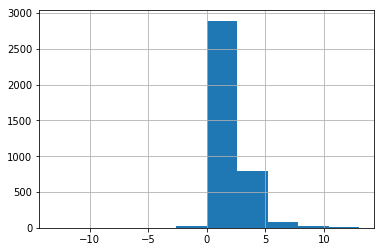

In [72]:
guests['diff'].hist();

There's at least one strange outlier. It seems the majority interpret "guests" to mean "additional person beyond yourself. But some seem to interpret as "total number of people staying." I think this means additional guests will typically incur a cost. I might create a "max occupancy covered by price" but it will require some assumptions.

In [77]:
# Explore min/max nights
listings[['minimum_nights', 'maximum_nights']].describe()

,minimum_nights,maximum_nights
count,3818.000000,3818.000000
mean,2.369303,780.447617
std,16.305902,1683.589007
min,1.000000,1.000000
25%,1.000000,60.000000
50%,2.000000,1125.000000
75%,2.000000,1125.000000
max,1000.000000,100000.000000


The majority have 1 or 2 minimum nights (no listings have 0). At least one listing has a maximum of 1. Most places seem to not really have a max, as they are listing values that are equivalent of 3 years+. 

In [78]:
# Explore calendar updated
listings.calendar_updated.unique()

array(['4 weeks ago', 'today', '5 weeks ago', '6 months ago',
       '7 weeks ago', '2 weeks ago', 'yesterday', '5 months ago',
       'a week ago', '5 days ago', '3 days ago', '2 months ago',
       '3 months ago', '4 days ago', '2 days ago', '3 weeks ago',
       '1 week ago', '13 months ago', '6 weeks ago', '8 months ago',
       '12 months ago', '4 months ago', 'never', '6 days ago',
       '10 months ago', '14 months ago', '9 months ago', '7 months ago',
       '30 months ago', '11 months ago', '22 months ago', '16 months ago',
       '15 months ago', '17 months ago'], dtype=object)

These could be converted to numerical values (equivalent days) if used to not require dummy variables. 

In [81]:
# Check if variation in has_availability
assert listings.has_availability.nunique() == 1

All listings have availability, can drop this column.

In [83]:
# Check if scrape date and calendar scrape date are the same
assert (listings.last_scraped == listings.calendar_last_scraped).sum() == listings.shape[0]

These are the same, can be dropped.

In [86]:
# Check if anyone requires license
listings.requires_license.value_counts()

f    3818
Name: requires_license, dtype: int64

No, can be dropped.

In [87]:
# Check if variation in jurisdiction
assert listings.jurisdiction_names.nunique() == 1

No, can be dropped

In [88]:
# Explore cancellation policies
print(listings.cancellation_policy.nunique())
listings.cancellation_policy.unique()

3


array(['moderate', 'strict', 'flexible'], dtype=object)

Three levels, easy to dummy.

In [90]:
# Check calculated_host_listings_count is the same as host_listings_count
(listings.calculated_host_listings_count == listings.host_listings_count).sum()

3189

For the most part (83.5% of the time), they do match. What is this second colum?

In [91]:
listings[['calculated_host_listings_count', 'host_listings_count']].head(10)

,calculated_host_listings_count,host_listings_count
0,2,3.0
1,6,6.0
2,2,2.0
3,1,1.0
4,1,2.0
5,1,1.0
6,1,1.0
7,5,5.0
8,1,1.0
9,6,6.0


It suggests that one of these is not accurate. Will need to do more work if going to determine which is accurate.

The dataset contains 92 columns and 3,818 rows of data. It looks as if this provides details for unique listings per row.

Details of the columns are as follows (data cleaning are in green, feature engineering in orange):
- **id**: Listing id, all unique, helpful for joining. <span style="color:green">Convert to str.</span>
- **listing_url**: The url for the listing of the form `https://www.airbnb.com/rooms/id`. <span style="color:green">Can be dropped.</span>
- **scrape_id**: The id of the data scrape by airbnb. <span style="color:green">Can be dropped.</span>
- **last_scraped**: The date of the scrape. <span style="color:green">Can be dropped.</span>
- **name**: Name selected by host for listing. <span style="color:orange">Could be useful for common term extraction.</span>
- **summary, space, description**: Text descriptions of the property provided by host. It appears that the information found in each of these can overlap. <span style="color:orange">Could be useful for common term extraction.</span>
- **experiences_offered**: All values are `none`. <span style="color:green">Can be dropped.</span>
- **neighborhood_overview**: Neighborhood description that looks to be provided by the host. Not always provided. 27% missing. <span style="color:orange">Could be useful for common term extraction.</span>
- **notes**: Additional information provided by the host. The information provided in this column can be quite variable. 42% missing. <span style="color:orange">Maybe just create missing dummy.</span>
- **transit**: Description of availability of public transport by host. 24% missing. <span style="color:orange">Text extraction likely quite helpful.</span>
- **thumbnail_url**: Link of the thumbnail image used for the listing. 8% missing. <span style="color:orange">Can create dummy for image present or not.</span>
- **medium_url**: Larger size of above. Same missing %. <span style="color:green">Can be dropped.</span>
- **picture_url**: Always has a picture url. What is the picture if thumbnail is missing? Otherwise, the same. <span style="color:green">Likely can be dropped.</span>
- **xl_picture_url**: Larger size of above. Same missing %. <span style="color:green">Can be dropped.</span>
- **host_id**: ID for the host, there are definitely hosts with multiple listings. <span style="color:green">Convert to str</span>
- **host_url**: url for host, same number as host_id. <span style="color:green">Can be dropped.</span>
- **host_name**: Seems just first name is typically used. Repeats because ppl have the same name. <span style="color:green">Can be dropped.</span>
- **host_since**: Date from when the host joined. <span style="color:green">Convert to unix date</span>
- **host_location**: Info provided by hosts. Typically of city, state, country format, but not consistent. 8 missing. <span style="color:orange">Needs cleaning to be interpretable.</span>
- **host_about**: Description provided by host. My contain location and employment/hobbies info. 22% missing. <span style="color:orange">Could be useful for common term extraction.</span>
- **host_response_time**: Ordinal categorization of response time with four levels. 14% missing. <span style="color:orange">Creat dummies.</span>
- **host_response_rate**: Percentage of whether they respond. 14% missing. <span style="color:green">Drop % and convert to int.</span>
- **host_acceptance_rate**: Almost all 100% (One 0%). 20% missing - does this mean no one has applied? <span style="color:orange">Can dummy for missing.</span>
- **host_is_superhost**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **host_thumbnail_url**: Url of host pic thumbnail. <span style="color:green">Can be dropped.</span>
- **host_picture_url**: Large version of above. <span style="color:green">Can be dropped.</span>
- **host_neighbourhood**: Seems to represent host location but distinct values. Can be in Seattle but can be elsewhere. 102 values. 8% missing. <span style="color:orange">Need to be combined with state/country for accurate location info.</span>
- **host_listings_count**: Seems to be number of listings per host. Only two missing. <span style="color:green">Double check data accuracy.</span>
- **host_total_listings_count**: Seems no different than above. <span style="color:green">Can be dropped.</span>
- **host_verifications**: List of methods(?) that host has been verified. <span style="color:green">Need to extract values if using.</span>
- **host_has_profile_pic**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **host_identity_verified**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **street**: Provides street, city, state abbr, zip code and country info for listing. <span style="color:green">Likely drop. Maybe extract missing zipcodes.</span>
- **neighbourhood**: <span style="color:green">Can be dropped because of below.</span>
- **neighbourhood_cleansed**: Provides neighbourhood details for the listing. <span style="color:orange">Maybe convert to dummy.</span>
- **neighbourhood_group_cleansed**: Provides wider grouping of listing location. <span style="color:orange">Maybe convert to dummy.</span>
- **city**: All values are the equivalent of Seattle <span style="color:green">Can be dropped.</span>
- **state**: All values are the equivalent of Washington <span style="color:green">Can be dropped.</span>
- **zipcode**: Zipcode of listing. <span style="color:green">Attempt to use `street` to extract missing values.</span>
- **market**: <span style="color:green">Can be dropped.</span>
- **smart_location**: All equivalent of Seattle. <span style="color:green">Can be dropped.</span>
- **country_code**: <span style="color:green">Can be dropped.</span>
- **country**: <span style="color:green">Can be dropped.</span>
- **latitude, longitude**: Coordinates for listing
- **is_location_exact**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **property_type**: Selection of property types. <span style="color:orange">Convert to dummies.</span>
- **room_type**: Three levels, entire, private, shared. <span style="color:orange">Convert to dummies.</span>
- **accommodates**: Max number of ppl able to be accommodated.
- **bathrooms**: Number of bathrooms in listing. >1% missing <span style="color:green">May drop missing.</span>
- **bedrooms**: Number of bedrooms in listing. >1% missing <span style="color:green">May drop missing.</span>
- **beds**: Number of beds in listing. 1 missing <span style="color:green">May drop missing.</span>
- **bed_type**: Five levels of bed type. <span style="color:orange">Convert to dummies.</span>
- **amenities**: List of available amenities. <span style="color:green">Need to extract values and manage entries that are null.</span>
- **square_feet**: Size of listing. 97% Missing. <span style="color:orange">Maybe dummy for missing.</span>
- **price**: Price of listing (at time of scrape?) <span style="color:green">Maybe drop because of calendar price.</span>
- **weekly_price**: Price per week (if available) <span style="color:green">Convert to numerical if using.</span>
- **monthly_price**: Price per month (if available) <span style="color:green">Convert to numerical if using.</span>
- **security_price**: Value of security deposit, if required. <span style="color:green">Create dummy for missing; convert to numerical.</span>
- **cleaning_fee**: Value of cleaning fee, if required. <span style="color:green">Create dummy for missing; convert to numerical.</span>
- **guests_included**: <span style="color:orange">Create "max accommodation included in price" column.</span>
- **extra_people**: Cost per extra person. <span style="color:green">Convert to numerical.</span>
- **minimum/maximum_nights**: <span style="color:green">May need to manage values over a year/maximum days available.</span>
- **calendar_update**: String of last time updated (I'm assuming compared to scrape day). <span style="color:green">Convert to days equivalent if using.</span>
- **has_availability**: All have availabilities. <span style="color:green">Can be dropped.</span>
- **availability_30/60/90/365**: Number of days listed as available in the interval (assuming from scrape date). <span style="color:green">Need to compare counts to listings.</span>
- **calendar_last_scraped**: <span style="color:green">Can be dropped.</span>
- **number_of_reviews**: Number of reviews received by host.
- **first/last_review**: Date of first/last review, not sure why some missing. <span style="color:green">Convert to date.</span>
- **review_scores_rating**: Some central measure of all ratings from 0 to 100. <span style="color:orange">May dummy missing.</span>
- **review_scores_accuracy/cleanliness/checkin/location/value**: Some central measure of the rating from 1 (low) to 10 (high) on the characteristic described. <span style="color:orange">May dummy missing.</span>
- **requires_license**: <span style="color:green">Can be dropped.</span>
- **license**: All null. <span style="color:green">Can be dropped.</span>
- **jurisdiction_names**: <span style="color:green">Can be dropped.</span>
- **instant_bookable**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **cancellation_policy**: Three levels. <span style="color:orange">Convert to dummies.</span>
- **require_guest_profile_picture/phone_verification**: Binary with 't' and 'f'. <span style="color:green">Convert to 1, 0.</span>
- **calculated_host_listings_count**: <span style="color:green">Needs further investigation to use.</span>
- **reviews_per_month**: As described. Same amount missing as first/last review. <span style="color:orange">May dummy missing.</span>

<a id="reviews"></a>
### 3.3. Reviews

In [92]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


This dataset contains information about reviews given by guests.

In [93]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
listing_id       84849 non-null int64
id               84849 non-null int64
date             84849 non-null object
reviewer_id      84849 non-null int64
reviewer_name    84849 non-null object
comments         84831 non-null object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


The dataset contains six columns and almost 85K rows of data.

#### Data Issues Identified
- **listing_id, id, reviewer_id**: <span style="color:green">convert to `str`</span>
- **date**: <span style="color:green"> convert to `datetime`</span>

The only feature with missing values is `comments`. It appears a small amount of people give some kind of review without leaving comments.

I'm not sure if I'm going to use this data. I could do some sentiment analysis, or work out how often people are repeat users of airbnb (based on those who comment), or at the same place. 

<a id='business'></a>
## 4. Business Understanding
After reviewing the available data, I decided that a potentially interesting approach would be to determine what features are associated with a host making a listing available, and whether it is possible to create a model that can predict whether a listing will be available. 

The scenario that I am wishing to address goes something like this:

_You stayed at a great airbnb location for your last vacation. You are thinking of going away in a few months, what is the likelihood that the host will have listed the place as available?_

Alternatively:

_You are scrolling through the airbnb site looking at different sites without having selected a date. Is there information that you use from this front page that may indicate that it is more likely that the host has listed the site as available for the dates you have in mind?_

It's important to note that with the information available, we don't have details of whether the available space was used, or how far in advance it was booked. So it's not possible to use this information to guarantee that the listing will be available when it's looked up, just that the host has made it avaialable. Hopefully, if people are searching far enough in advance, this is less of an issue.

One of the key elements of these questions is that the information that we are talking about needs to be salient to the users of the site. If a particular element is identified as having high importance in prediction but is not easily avaialable to someone viewing the site, this would be less helpful information. 

As a result, it's important to understand what information is available to people when viewing the listings. This is what the front page of homes looks like after searching for Seattle, WA.

![home_page](front_page.PNG)

There is an option at the bottom of this preview of listings to see all. Clicking on this link shows the following view:

![details](detail_page.PNG)

Based on these images, information that is quickly available when viewing the site includes:
- The property type
- Whether the place is shared or not
- The number of beds
- The name of the listing
- The cost per night
- The rating for the host (out of six stars)
- The number of ratings received
- Whether they are considered a superhost
- With the map on the side, it's also possible to use location based searches
- Whether cancellation is free

For someone who has stayed at the listing and is thinking of returning, other known information could include:
- Number of bedrooms and bathrooms
- Some of the available amenities
- The location

As a result, if any of these features are helpful in predicting avaiability, they would be considered very useful.

One element that is shown on the current site is a `Plus` indicator. Based on [information on the site](https://www.airbnb.ca/plus) this indicates very high quality listings, both in terms of the place to stay, and the host. However, this appears to be a new element of airbnb. As a result, it likely is not captured in the 2016 information available to us. 

<a id='data'></a>
## 5. Data Understanding

With an understanding of the business needs, it is also possible to make some further determinations about what information is appropriate to include as potential features for our model.

<a id="listing"></a>
### 5.1. Listing Information
For example, based on these details, I am going to include some term extraction for the listing name, but will exclude any analysis of 
- summary
- space
- description 
- neighborhood_overview
- notes 
These are fields in which the information will not be easily avaible to the potential guests of our imagined scenarios. This reduces the amount of text extraction needed and also the number of potential dummy variables.

The framing of the business case also suggests that the following fields can be excluded because they are either not easily available in the imagined scenario, their interpretation is challenging, or they potentially add limited information.
- guests_included
- calendar_update
- first/last_review
- reviews_per_month
- square_feet

While transit seems like relevant information, it's not data that is clearly available on the current navigation screen of the site, so I will only include this field as a dummy representing a discussion of transport or not. 

<a id="host"></a>
### 5.2. Host Information
I'll also drop some of the host information that would not be easily available in our imagined scenarios:
- host_location
- host_about
- host_neighbourhood
- host_verifications
- host_acceptance_rate

While this information is not available in our scenarios, I'm including it to see if there is any relevance:
- host_response_time
- host_response_rate
- host_listings_count
- host_has_profile_pic
- host_identity_verified

I'll also definitely be including whether the host is a superhost.

<a id="review"></a>
### 5.3. Review Information
Because of the business case proposed, I'm going to exclude any analysis of the reviews. 

<a id="date"></a>
### 5.4. Date Information
One of the key elements of this data is date information. Common key features to consider when analyzing date information (References: [1](https://datascience.stackexchange.com/questions/2368/machine-learning-features-engineering-from-date-time-data), [2](https://www.salford-systems.com/blog/dan-steinberg/using-dates-in-data-mining-models)) can include what day of the week it is, the season of the year, and whether special events are occurring. These all seem relevant to the current business case. 

As a result, I plan to create dummy variables for the day of the week and season based on calendar dates. I will also identify key vacation periods that might be relevant to when people would typically look for accommodation. Once these are done, I will exclude the actual dates. 

There is also a date field of `host_since`. This is best understood as a measure of recency. As a result, I will be converting this to a unix representation of date to provide clear intervals between dates.

<a id='prep'></a>
## 6. Data Preparation

<a id="clean"></a>
### 6.1. Cleaning

In [4]:
# Make copies of the initial datasets
df_cal = calendar.copy()
df_list = listings.copy()

<a id='zipcode'></a>
#### 6.1.1. Missing zipcodes
Determine if missing values in `zipcode` can be extracted from `street`. If so, replace `zipcode` with `.str.split(',')[-2]` from `street`.

In [4]:
# Compare missing for each field
(df_list.zipcode.isna() == df_list.street.isna()).sum()

3811

The majority are the same but some are different, it may be possible to extract.

In [5]:
# Investigate street info for missing zipcodes
df_list[['zipcode', 'street']][df_list.zipcode.isna()]

,zipcode,street
162,NaN,"Seattle, WA, United States"
479,NaN,"14th Avenue West, Seattle, WA, United States"
988,NaN,"-30th. Ave., Seattle, WA, United States"
1672,NaN,"Seattle, WA, United States"
1917,NaN,"Seattle, WA, United States"
2521,NaN,"Harvard Avenue East, Seattle, WA, United States"
2671,NaN,"Seattle, WA, United States"


When zipcode information is missing, it is not included in the street details, therefore these values cannot be replaced. 

<a id="join"></a>
#### 6.1.2. Join datasets
Combine two datasets towards creating a tidy master using `pd.merge()` with a left join on `df_cal`. Drop `listing_id` once merged.

In [5]:
df = pd.merge(df_cal, df_list, how='left', left_on='listing_id', right_on='id')
df.drop('listing_id', axis=1, inplace=True)

In [7]:
df.head()

,date,available,price_x,id,listing_url,scrape_id,last_scraped,name,summary,space,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2016-01-04,t,$85.00,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,2016-01-05,t,$85.00,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
2,2016-01-06,f,NaN,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
3,2016-01-07,f,NaN,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
4,2016-01-08,f,NaN,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [5]:
# Test: confirm columns and rows are correct
assert df.shape[1] == (df_cal.shape[1] + df_list.shape[1] - 1)
assert df.shape[0] == df_cal.shape[0]

<a id="unnecessary"></a>
#### 6.1.3. Drop unnecessary columns
Create list based on assessment and business case. The merge resulted in two price columns. Need to drop `price_y` and convert `price_x` to `price`.

In [6]:
drop_cols = ['listing_url', 'scrape_id', 'last_scraped', 'experiences_offered', 
             'neighborhood_overview', 'notes', 'medium_url', 'picture_url', 
             'xl_picture_url', 'host_url', 'host_name', 'host_location', 
             'host_about', 'host_thumbnail_url', 'host_picture_url', 
             'host_neighbourhood', 'host_total_listings_count', 
             'host_verifications', 'street', 'neighbourhood', 'city', 'state', 
             'market', 'smart_location', 'country_code', 'country', 'price_y',
             'weekly_price', 'monthly_price', 'guests_included', 
             'calendar_updated', 'has_availability', 'calendar_last_scraped', 
             'first_review', 'last_review', 'requires_license', 'license', 
             'jurisdiction_names', 'reviews_per_month', 'square_feet']

df_drop_cols = df.drop(drop_cols, axis=1)

In [7]:
df_drop_cols.rename(columns={'price_x': 'price'}, inplace=True)

In [8]:
# Test: Confirm correct column number
assert df_drop_cols.shape[1] == df.shape[1] - len(drop_cols)
# Test: Confirm presence of price in columns
assert 'price' in df_drop_cols.columns

<a id="rows"></a>
#### 6.1.4. Drop specified rows with missing values
Columns that have missing values where rows will be dropped are:
- bathrooms
- bedrooms
- beds
- host_is_superhost

In [8]:
drop_rows = ['bathrooms', 'bedrooms', 'beds', 'host_is_superhost']
df_drop_rowcol = df_drop_cols.dropna(subset=drop_rows)

In [10]:
# Test: Confirm correct row count
assert df_drop_cols.shape[0] - df_drop_rowcol.shape[0] \
       == (df_drop_cols[drop_rows].isna().sum(axis=1) > 0).sum()

<a id="str"></a>
#### 6.1.5. Convert columns to `str`
Create a copy of the df and then convert relevant columns to `str`. The columns that need to be converted to `str` are:
- id
- host_id

In [9]:
df_convert_str = df_drop_rowcol.copy()
str_cols = ['id', 'host_id']
df_convert_str.loc[:, str_cols] = df_convert_str[str_cols].astype(str)

In [12]:
# Test: Confirm two more object columns
assert (df_drop_rowcol.dtypes == object).sum() \
       == ((df_convert_str.dtypes == object).sum() - len(str_cols))

<a id="bool"></a>
#### 6.1.6. Convert columns to `1`, `0`
Create new copy of df. Convert columns correctly coded with `t` and `f` to `1` and `0` respectively. Columns that need to be converted are:
- available
- host_is_superhost
- host_has_profile_pic
- host_identity_verified
- is_location_exact
- instant_bookable
- require_guest_profile_picture
- require_guest_phone_verification

Double check that there is variations in the value counts before converting. If no variation, then drop.

In [10]:
bool_cols = ['available', 'host_is_superhost', 'host_has_profile_pic', 
             'host_identity_verified', 'is_location_exact', 'instant_bookable', 
             'require_guest_profile_picture', 'require_guest_phone_verification']

for col in bool_cols:
    print('\n')
    print(col)
    print(df_convert_str[col].value_counts())



available
t    927644
f    457166
Name: available, dtype: int64


host_is_superhost
f    1100840
t     283970
Name: host_is_superhost, dtype: int64


host_has_profile_pic
t    1382255
f       2555
Name: host_has_profile_pic, dtype: int64


host_identity_verified
t    1087335
f     297475
Name: host_identity_verified, dtype: int64


is_location_exact
t    1237350
f     147460
Name: is_location_exact, dtype: int64


instant_bookable
f    1170555
t     214255
Name: instant_bookable, dtype: int64


require_guest_profile_picture
f    1269105
t     115705
Name: require_guest_profile_picture, dtype: int64


require_guest_phone_verification
f    1249395
t     135415
Name: require_guest_phone_verification, dtype: int64


Each has values for both levels, so convert all.

In [11]:
df_str_bool = df_convert_str.copy()
df_str_bool.loc[:, bool_cols] = df_str_bool[bool_cols].replace({'t': 1, 'f': 0})

In [16]:
# Test: Confirm more int columns
assert (df_str_bool.dtypes == 'int64').sum() \
       == ((df_convert_str.dtypes == 'int64').sum() + len(bool_cols))

<a id="price"></a>
#### 6.1.7. Convert price/percent columns to `float`
Copy df. Use `.str.strip()` to replace `\$` and `%`. Use `.str.replace(',','')` to manage commas in values. Then convert to `float`. Columns that need to be converted are:
- host_response_rate (%)
- security_deposit (\$)
- cleaning_fee (\$)
- extra_people (\$)
- price (\$)

In [12]:
df_str_bool_flt = df_str_bool.copy()
num_cols = ['host_response_rate', 'security_deposit', 'cleaning_fee', 
            'extra_people', 'price']

# Make the replacements
for col in num_cols:
    df_str_bool_flt.loc[:, col] = df_str_bool_flt[col].str.strip('%$').str.replace(",", "").astype(float)

In [18]:
# Test: Confirm more float columns
assert (df_str_bool_flt.dtypes == 'float64').sum() \
       == ((df_str_bool.dtypes == 'float64').sum() + len(num_cols))

<a id="datetime"></a>
#### 6.1.8. Convert columns to `datetime`
Copy df. Convert columns to date. Relevant columns are:
- host_since
- date

In [13]:
df_dtypes = df_str_bool_flt.copy()
date_cols = ['host_since', 'date']

for col in date_cols:
    df_dtypes.loc[:, col] = pd.to_datetime(df_dtypes[col])

In [77]:
df_dtypes[date_cols].dtypes

host_since    datetime64[ns]
date          datetime64[ns]
dtype: object

In [20]:
# Test: Confirm more datetime columns
assert (df_dtypes.dtypes == 'datetime64[ns]').sum() \
       == ((df_str_bool_flt.dtypes == 'datetime64[ns]').sum() + len(date_cols))

<a id="unix"></a>
#### 6.1.9. Convert `host_since` to unix time
Convert to type `np.int64`.

In [14]:
df_dtypes.host_since = df_dtypes.host_since.astype(np.int64)

In [22]:
# Test: Confirm 1 more int64 column
assert (df_dtypes.dtypes == 'int64').sum() \
       == ((df_str_bool_flt.dtypes == 'int64').sum() + 1)

<a id="amen"></a>
#### 6.1.10. Extract amenities

1. Confirm that all missing info is represented by `{}`. 
1. Make a copy of the df.
2. Strip remaining `{}`.
3. Replace " with empty string. 
4. Create a new amenities df with `.str.split(',', expand=True)`.
5. Determine the set of unique values.
6. Create dummy variables for amenities using unique amenity values as column names and `.str.contains(amenity)` to create bool values.
6. Drop the amenities column. 

In [81]:
# Check value counts
df_dtypes.amenities.value_counts()[:5]

{}                                                                                                                                                                                                                                                                                                                                                                                         14965
{Internet,"Wireless Internet",Kitchen,"Free Parking on Premises",Heating,Washer,Dryer}                                                                                                                                                                                                                                                                                                      4015
{TV,"Cable TV",Internet,"Wireless Internet",Pool,Kitchen,"Free Parking on Premises",Gym,"Elevator in Building","Hot Tub",Heating,"Family/Kid Friendly",Washer,Dryer,"Smoke Detector","Carbon Monoxide Detector","Fire Extinguisher",Es

In [15]:
df_clean_amen = df_dtypes.copy()

In [16]:
# Clean text
df_clean_amen.amenities = df_clean_amen.amenities.str.strip('{}').str.replace('"', '')

# Extract unique values
df_amenities = df_clean_amen.amenities.str.split(',', expand=True)
amenities = pd.unique(df_amenities.values.ravel('K'))

In [84]:
amenities

array(['TV', 'Internet', 'Wireless Internet', 'Cable TV',
       'Air Conditioning', '', 'Kitchen', 'Elevator in Building',
       'Wheelchair Accessible', 'Smoke Detector',
       'Free Parking on Premises', 'Pool', 'Pets live on this property',
       None, 'Breakfast', 'Gym', 'Heating', 'Washer',
       'Buzzer/Wireless Intercom', 'Smoking Allowed',
       'Carbon Monoxide Detector', 'Pets Allowed', 'Indoor Fireplace',
       'Dryer', 'Dog(s)', 'Family/Kid Friendly', 'Hot Tub', 'Cat(s)',
       'Essentials', 'Shampoo', 'First Aid Kit', 'Doorman',
       'Fire Extinguisher', 'Safety Card', 'Washer / Dryer',
       'Suitable for Events', 'Other pet(s)', 'Hangers',
       '24-Hour Check-in', 'Laptop Friendly Workspace',
       'Lock on Bedroom Door', 'Hair Dryer', 'Iron'], dtype=object)

There is `None` in the list which will likely create an exception, so need to manage that. 

In [17]:
for amenity in amenities:
    try:
        df_clean_amen[amenity] = df_clean_amen.amenities.str.contains(amenity)
    except:
        continue

C:\Users\rebecca-barnes\Anaconda3\envs\dand\lib\site-packages\ipykernel\__main__.py:3: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  app.launch_new_instance()


In [18]:
# Drop original amenities
df_clean_amen.drop('amenities', axis=1, inplace=True)

In [27]:
# Test: Correct number of new columns
assert df_clean_amen.shape[1] == df_dtypes.shape[1] + len(amenities) - 2
# Test: Confirm correct datatype
assert (df_clean_amen.loc[:, 'TV':].dtypes == bool).sum() == len(amenities) - 1

<a id="remain"></a>
#### 6.1.11. Manage remaining columns

In reviewing the work needed for the remaining columns that were identified as neededing cleaning:
- host_listings_count
- minimum_nights
- maximum_nights
- availability_30
- availability_60
- availability_90
- availability_365
- calculated_host_listings_count
- summary
- space
- description
- transit
- host_response_rate
- host_acceptance_rate

Upon further consideration, I decided that given that this information was not immediately available in the imagined business case that I would drop these columns.

I can also drop:
- host_id
- zipcode

In [19]:
drop_cols = ['host_listings_count', 'minimum_nights', 'maximum_nights', 
             'availability_30', 'availability_60', 'availability_90', 
             'availability_365', 'calculated_host_listings_count', 
             'summary', 'space', 'description', 'transit', 
             'host_acceptance_rate', 'host_response_rate', 'is_location_exact', 
             'host_id', 'zipcode']

df_clean = df_clean_amen.drop(drop_cols, axis=1)

In [29]:
# Test: Columns have been dropped
assert df_clean.shape[1] == df_clean_amen.shape[1] - len(drop_cols)

In [53]:
# Save cleaned df
df_clean.to_csv('data/data_clean.csv', index=False)

This concludes the data cleaning. It is now time to move on to feature engineering.

<a id="engineer"></a>
### 6.2. Feature Engineering

Feature engineering will be split into two sections - feature engineering that does not require imputation and therefore will be done on the entire dataset, then, once the data has been split, a pipeline will be created to manage train and test data. 

In [40]:
# Designate dtypes to prevent mixed types
dtype={"available": int, "id": str, "date": str, "price": float, "name": str, 
       "host_since": int, "host_response_time": str, "host_is_superhost": int, 
       "thumbnail_url": str,        "host_has_profile_pic": int, 
       "host_identity_verified": int, "neighbourhood_cleansed": str, 
       "neighbourhood_group_cleansed": str, "latitude": float, "longitude": float, 
       "property_type": str, "room_type": str, "accommodates": int, 
       "bathrooms": float, "bedrooms": float, "beds": float, "bed_type": str,
       "security_deposit": float, "cleaning_fee": float, "extra_people": float,
       "number_of_reviews": int, "review_scores_rating": float, 
       "review_scores_accuracy": float, "review_scoares_cleanliness": float,
       "review_scores_checkin": float, "review_scores_communication": float,
       "review_scores_location": float, "review_scores_value": float, 
       "instant_bookable": int, "cancellation_policy": str, 
       "require_guest_profile_picture": int, 
       "require_guest_phone_verification": int}

In [41]:
df_clean = pd.read_csv('data/data_clean.csv', dtype=dtype, 
                       date_parser=pd.to_datetime, parse_dates=['date'])

<a id="balance"></a>
#### 6.2.1. Balance the response

One of the characteristics of the dataset is that the response levels are somewhat imbalanced.

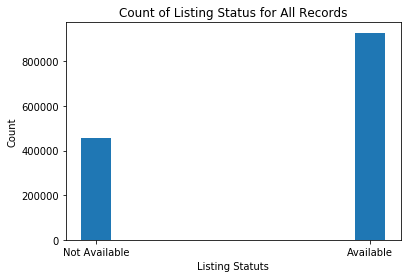

In [35]:
# Split into signals and response
y = df_clean['available']
X = df_clean.drop('available', axis=1)

# Explore balance of response
y.hist(grid=False)
plt.xticks([0.05, 0.95], ['Not Available', 'Available'])
plt.xlabel('Listing Statuts')
plt.ylabel('Count')
plt.title('Count of Listing Status for All Records');

There is some imbalance, with approximately double the number of dates with availability compared to those without. Because this is such a large dataset, it is possible to balance this out by dropping some of the "available" entries. Let's sample from the original dataset and recreate `y` and `X`.

In [20]:
# Get number of "not available"
not_available = df_clean[df_clean['available'] == 0]
n_not_available = not_available.shape[0]

# Sample this from "available" records
available = df_clean[df_clean['available'] == 1].sample(n_not_available, random_state=42)

# Join together and create new X and y
df_balanced = pd.concat([not_available, available])
df_balanced.to_csv('data/data_balanced.csv')
X_balanced = df_balanced.drop('available', axis=1)
y_balanced = df_balanced['available']

X_balanced.shape[0]

914332

The new dataset now has 914k rows. Just to confirm that our dataset is now balanced:

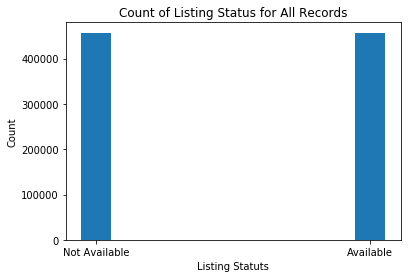

In [37]:
# Explore balance of response
y_balanced.hist(grid=False)
plt.xticks([0.05, 0.95], ['Not Available', 'Available'])
plt.xlabel('Listing Statuts')
plt.ylabel('Count')
plt.title('Count of Listing Status for All Records');

<a id="cat"></a>
#### 6.2.2. Convert categorical columns to dummies
Relevant columns are:
- host_response_time
- neighbourhood_cleansed
- neighbourhood_group_cleansed
- property_type
- room_type
- bed_type
- cancellation_policy

Solution:
1. Create df for dummies. 
2. Merge back on index.
3. Drop original columns.

In [21]:
cat_cols = ['host_response_time', 'neighbourhood_cleansed', 
            'neighbourhood_group_cleansed', 'property_type', 'room_type', 
            'bed_type', 'cancellation_policy']

# Create dummies
df_cat_cols = pd.get_dummies(X_balanced[cat_cols], dummy_na=True)
# Join back on
X_cat_dummies = pd.merge(X_balanced, df_cat_cols, left_index=True, right_index=True)
# Drop cols
X_cat_dummies.drop(cat_cols, axis=1, inplace=True)

<a id="date-feat"></a>
#### 6.2.3. Create date dummies
As stated previously, there are three types of date dummy variables I would like to create - day of the week, season, and holiday dates.

Solution:
1. Create a copy of the df
2. Day of the week: Create a new column with `.dt.dayofweek`
3. Define dates for each season, create bool column for each 
4. Define dates for each holiday, create bool column for each 

In [22]:
X_date_dummies = X_cat_dummies.copy()

# Create weekday column
X_date_dummies['weekday'] = X_date_dummies.date.dt.dayofweek
# Test: seven unique values
assert X_date_dummies.weekday.nunique() == 7
# Test: range from 0 to 6
assert (X_date_dummies.weekday.min() == 0) & (X_date_dummies.weekday.max() == 6)

In [23]:
# Define seasons (end is before second date)
summer = ('2016-06-20', '2016-09-22')
fall = ('2016-09-22', '2016-12-21')
winter_end_of_year = ('2016-12-21', '2017-03-20')
winter_start_of_year = ('2016-01-01', '2016-03-19')
spring = ('2016-03-19', '2016-06-20')

# Create list of seasons and names
seasons = [summer, fall, spring]
names = ['summer', 'fall', 'spring']

# Create columns
for season, name in zip(seasons, names):
    X_date_dummies[name] = (season[0] <= X_date_dummies.date) & (X_date_dummies.date < season[1])

X_date_dummies['winter'] = ((winter_end_of_year[0] <= X_date_dummies.date) & (X_date_dummies.date < winter_end_of_year[1])) \
                           | ((winter_start_of_year[0] <= X_date_dummies.date) & (X_date_dummies.date < winter_start_of_year[1]))

In [58]:
# Test: Sum of season columns should equal rows
assert X_date_dummies.loc[:, 'summer':'winter'].sum().sum() \
       == X_date_dummies.shape[0]

This [resource](https://www.officeholidays.com/countries/usa/regional.php?list_year=2016&list_region=Washington) was used to confirm holiday dates.

In [24]:
# Collect federal/state holidays
new_year = ['new_year', 'Friday', '2016-01-01']
mlk = ['mlk', 'Monday', '2016-01-16']
presidents = ['presidents', 'Monday', '2016-02-15']
memorial = ['memorial', 'Monday', '2016-05-30']
fourth_july = ['fourth_july', 'Monday', '2016-07-04']
labor = ['labor', 'Monday', '2016-09-05']
veteran = ['veteran', 'Friday', '2016-11-11']
thanksgiving = ['thanksgiving', 'Thursday', '2016-11-24']
christmas = ['christmas', 'Monday', '2016-12-26']

holidays = [new_year, mlk, presidents, memorial, fourth_july, labor, 
            veteran, thanksgiving, christmas]

# Define start and end for each holiday
for holiday in holidays:
    hol_date = datetime.strptime(holiday[2], '%Y-%m-%d')
    if holiday[1] == 'Monday':
        # Start date is the Friday before
        holiday.append(hol_date - timedelta(days=3))
        # End date is the day after
        holiday.append(hol_date + timedelta(days=1))
    if holiday[1] == 'Friday':
        # Start date is the day before
        holiday.append(hol_date - timedelta(days=1))
        # End date is the Monday after
        holiday.append(hol_date + timedelta(days=3))
    if holiday[1] == 'Thursday':
        # Start date is the day before
        holiday.append(hol_date - timedelta(days=1))
        # End date is the Monday after
        holiday.append(hol_date + timedelta(days=4))

# Create columns
for holiday in holidays:
    X_date_dummies[holiday[0]] = (holiday[-2] \
                                  <= X_date_dummies.date) \
                                 & (X_date_dummies.date < holiday[-1])

In [44]:
# Test: New # bool columns are the same as # holidays + seasons 
assert (X_date_dummies.dtypes == bool).sum() \
       == (X_cat_dummies.dtypes == bool).sum() + len(holidays) + 4

This [resource](https://www.seattleschools.org/UserFiles/Servers/Server_543/File/District/Departments/School%20Board/16-17agendas/05_17_2017/I01_20170517_Action_Report_2017-18_School_Calendar.pdf) was used to confirm school holidays:
- Winter Break: At least ten weekdays, ending after New Year’s Day. If New Year’s Day falls or is observed on a Monday, students will return to school on the next day (Tuesday).
- Mid-Winter Break: President’s Day and the following four workdays.
- Spring Break: Five days starting the second Monday in April.
- Summer Break: From last day of school (June 22) to first day of school (first Wed in Sep - 7th)

In [25]:
# Collect school holidays
winter_break = ['winter_break', '2016-12-19', '2017-01-02']
mid_winter_break = ['mid_winter_break', '2016-02-15', '2016-02-22']
spring_break = ['spring_break', '2016-04-11', '2016-04-18']
summer_break = ['summer_break', '2016-06-22', '2016-09-07']

school_hols = [winter_break, mid_winter_break, spring_break, summer_break]

# Create columns
for holiday in school_hols:
    X_date_dummies[holiday[0]] = (holiday[1] <= X_date_dummies.date) & (X_date_dummies.date < holiday[2])

In [46]:
# Test: New # bool columns are the same as # holidays + seasons + school_hols
assert (X_date_dummies.dtypes == bool).sum() \
       == (X_cat_dummies.dtypes == bool).sum() + len(school_hols) \
       + len(holidays) + 4
# Test: Review names of last added columns
X_date_dummies.columns[-(len(school_hols) + len(holidays) + 4):]

Index(['summer', 'fall', 'spring', 'winter', 'new_year', 'mlk', 'presidents',
       'memorial', 'fourth_july', 'labor', 'veteran', 'thanksgiving',
       'christmas', 'winter_break', 'mid_winter_break', 'spring_break',
       'summer_break'],
      dtype='object')

Now that dummies have been created for date, the exact dates are no longer needed.

In [26]:
X_date_dummies.drop('date', axis=1, inplace=True)

<a id="split"></a>
#### 6.2.4. Train-Test split

Because some of the next steps will involve imputing values and other preprocessing, it is time to split the data into train and test sets. I'll be using a pipeline to manage cross-validation. 

This is a very large dataset, so only a small amount is really needed for training. I'm looking for a training set of 10% of the data. The test set can then be sampled as needed.

In [27]:
# Implement train-test split with 10% as training
X_train, X_test, y_train, y_test = train_test_split(X_date_dummies, y_balanced, test_size=0.9, random_state=42)

# Save datasets
files = [X_train, y_train, X_test, y_test]
names = ['X_train', 'y_train', 'X_test', 'y_test']
folder = 'data'

for file, name in zip(files, names):
    file.to_csv(os.path.join(folder, name + '.csv'), index=False)
    print(name + ":", file.shape)

X_train: (91433, 230)
y_train: (91433,)
X_test: (822899, 230)
y_test: (822899,)


There are now 91k rows in the training set, almost 823k entries available for testing.

<a id="skew"></a>
#### 6.2.5. Review distribution skew

The remaining transformations will be completed in a data pipeline but the data needs to be explored to determine what transformations are required.

Let's check the skew of the numerical features.

In [42]:
dtype={"price": float, "name": str, 
       "host_since": int, "host_response_time": str, "host_is_superhost": int, 
       "host_has_profile_pic": int, "host_identity_verified": int, 
       "neighbourhood_cleansed": str, "neighbourhood_group_cleansed": str,
       "latitude": float, "longitude": float, 
       "property_type": str, "room_type": str, "accommodates": int, 
       "bathrooms": float, "bedrooms": float, "beds": float, "bed_type": str,
       "security_deposit": float, "cleaning_fee": float, "extra_people": float,
       "number_of_reviews": int, "review_scores_rating": float, 
       "review_scores_accuracy": float, "review_scoares_cleanliness": float,
       "review_scores_checkin": float, "review_scores_communication": float,
       "review_scores_location": float, "review_scores_value": float, 
       "instant_bookable": int, "cancellation_policy": str, 
       "require_guest_profile_picture": int, 
       "require_guest_phone_verification": int}

X_train = pd.read_csv('data/X_train.csv', dtype=dtype)

In [73]:
X_train.columns.get_loc('host_response_time_a few days or more')

68

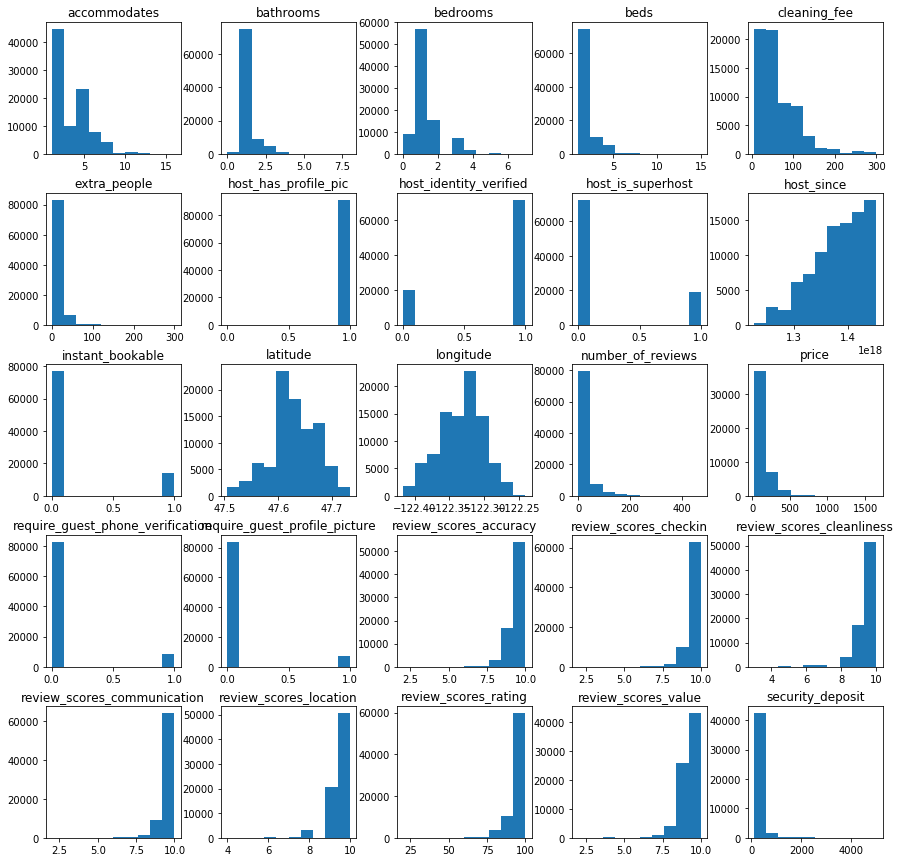

In [74]:
# Exclude bools and newly created columns
non_bool_col = X_train.iloc[:, :68].dtypes[X_train.dtypes != bool].index

# Plot hist of distributions
X_train[non_bool_col].hist(grid=False, figsize=(15, 15));

In [128]:
skew_scores = X_train.skew()
skew_scores[np.abs(skew_scores) > 2]

price                                3.249416
host_has_profile_pic               -22.858173
bathrooms                            3.047324
beds                                 2.411026
security_deposit                     6.476373
extra_people                         4.815319
number_of_reviews                    4.101309
review_scores_rating                -3.181602
review_scores_accuracy              -3.341576
review_scores_cleanliness           -2.628972
review_scores_checkin               -5.371203
review_scores_communication         -5.976459
review_scores_value                 -2.307460
require_guest_profile_picture        3.061861
require_guest_phone_verification     2.791706
Internet                            -5.389578
Wireless Internet                   -4.843366
Kitchen                             -2.703508
Wheelchair Accessible                3.106401
Smoke Detector                      -2.166262
Pool                                 4.757998
Breakfast                         

Many of features are highly skewed (|skew| above 2) and would benefit from log transformation. However, I'll only be transforming non-binary values. ([Reference](http://www.talkstats.com/threads/log-transformation-of-binary-variables.19623/))

In [29]:
skewed = ['price', 'bathrooms', 'beds', 'security_deposit', 'extra_people', 
          'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
          'review_scores_cleanliness', 'review_scores_checkin', 
          'review_scores_communication', 'review_scores_value']

Skewed columns will be transformed with `.apply(lambda x: np.log(x + 0.01))`.

<a id="text"></a>
#### 6.2.5. Text extraction

It seemed possible that the words in the posting name could give insight into posting availability. Let's implement a couple of standard NLP processes while limiting the number of features created to 30.

I'll create a `tokenize` function and then complete the rest of it in the pipeline.

In [250]:
def tokenize(text):
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = [lemmatizer.lemmatize(tok).lower().strip() for tok in tokens]

    return clean_tokens

The pipeline component will include:
`TfidfVectorizer(tokenizer=tokenize, stop_words='english', max_features=30)`

<a id="missing"></a>
#### 6.2.6. Explore missing values
There are a number of columns with missing values. It is worth investigating whether these rows should be dropped, imputed, and/or dummy variables for missing created. 

The relevant columns are:
- security_deposit
- cleaning_fee
- review_scores_rating
- review_scores_accuracy
- review_scores_cleanliness
- review_scores_checkin
- review_scores_location
- review_scores_value

In [6]:
explore_cols = ['security_deposit', 'cleaning_fee', 'review_scores_rating', 
                'review_scores_accuracy', 'review_scores_cleanliness', 
                'review_scores_checkin', 'review_scores_location', 
                'review_scores_value']

In [7]:
X_train[explore_cols].describe()

,security_deposit,cleaning_fee,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_location,review_scores_value
count,44868.000000,66638.000000,75317.000000,75012.000000,75158.000000,75031.000000,75103.000000,75072.000000
mean,289.941183,60.788754,94.604777,9.643470,9.562216,9.788634,9.614955,9.469629
std,283.430294,47.902249,6.726488,0.696387,0.798253,0.607990,0.629379,0.757821
min,95.000000,5.000000,20.000000,2.000000,3.000000,2.000000,4.000000,2.000000
25%,150.000000,25.000000,93.000000,9.000000,9.000000,10.000000,9.000000,9.000000
50%,250.000000,50.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,300.000000,80.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000
max,5000.000000,300.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000


For `security_deposit` and `cleaning_fee` all minimums are above 0. This suggests that when the value is missing, there is no cost for these features. Therefore missing values can be filled with 0.

How many missing values are there for the remaining columns?

In [9]:
X_train[explore_cols[2:]].isna().sum()

review_scores_rating         16116
review_scores_accuracy       16421
review_scores_cleanliness    16275
review_scores_checkin        16402
review_scores_location       16330
review_scores_value          16361
dtype: int64

What's interesting here is that the counts for the missing values are actually quite similar. Are there patterns in what is missing?

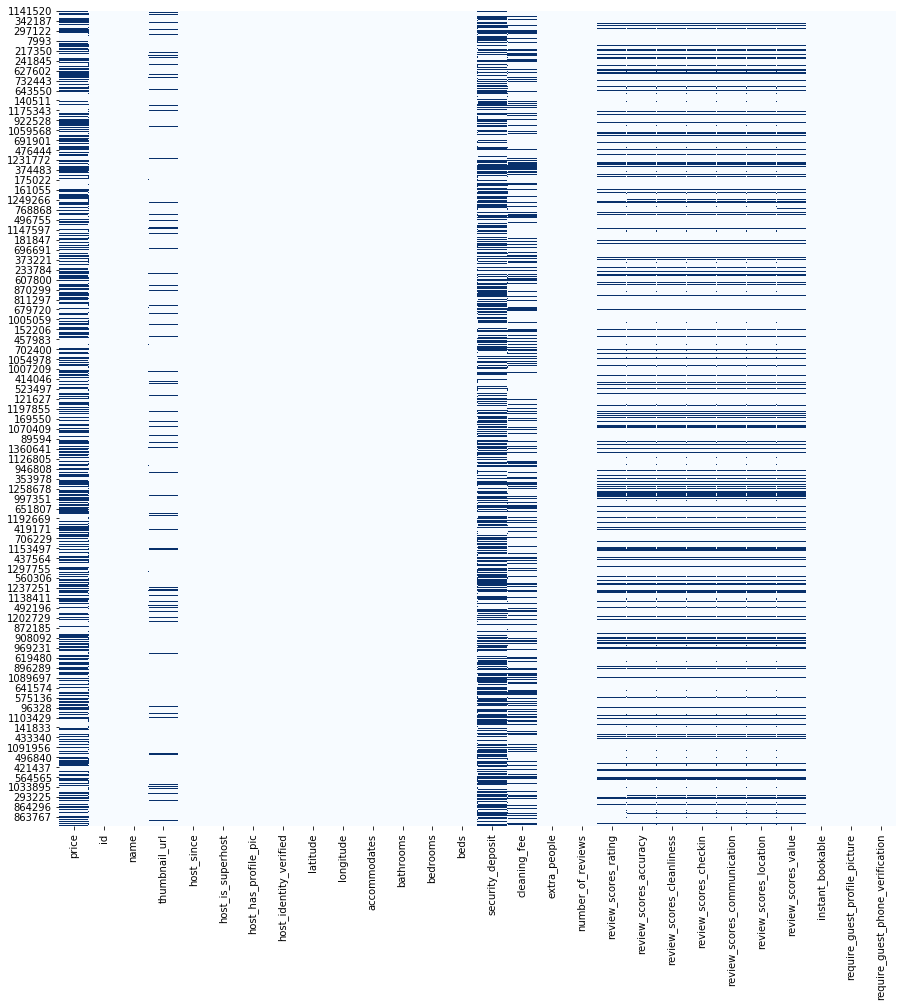

In [30]:
# Plot pattern of missing values - dark blue are missing
plt.figure(figsize=(15,15))
sns.heatmap(X_train.loc[:, :'require_guest_phone_verification'].isna(),\
            cmap='Blues', cbar=False); 

It is clear that when one rating is missing, it is very likely that other ratings are missing. There does not seem to be a clear relationship between the pattern of missing ratings and missing values in other areas. 

Other observations include the fact that most people do not require a security deposit. More than 50% also don't seem to require a cleaning fee, but more people require a cleaning fee than a security deposit. (This seems to make some sense as returning security deposits can be challenging to manage, but most visits do require cleaning)

The missing thumbnails can just be used to determine if the listing has a picture or not.

The final decision to manage is what to do with the missing values for price and the ratings. 

Price is missing when the listing is not available. These could be filled with 0, but that would seem to create a distortion of the impact of price when predicting availability. The price for a listing when it is unavailable could essentially be assumed to be the same as the most recent price after it, or before it, as necessary. If a listing doesn't have the ability to reference other values, it will be imputed with the mean. (This is acceptable as price will be transformed to reduce skew)

The variation in ratings is relatively small for each feature - the std is less than 10% of the maximum rating for each score. Therefore I plan to simply impute the mean here. I will also include a dummy variable for missing values prior to imputing.

Classes will be built to complete these transformations within the pipeline.

<a id="model"></a>
## 7. Model

Let's first create a function that allows us to add all of the columns to dummy missing values.

In [43]:
def create_missing_dummies(df, copy=True):
    '''
    Create dummy columns for missing values of reviews and thumbnail_url
    and drops the thumbnail_url column.
    
    Inputs:
        df: (pandas dataframe) Contains the columns ['review_scores_rating', 
            'review_scores_accuracy', 'review_scores_cleanliness', 
            'review_scores_checkin', 'review_scores_location', 
            'review_scores_value', 'review_scores_communication', 'thumbnail_url']
        copy: (bool) Indicates whether a copy of the original df should be created.
    
    Outputs:
        df (pandas dataframe)
    '''
    if copy:
        df = df.copy()
    
    # Create dummy columns for missing ratings
    missing_cols = ['review_scores_rating', 'review_scores_accuracy', 
                    'review_scores_cleanliness', 'review_scores_checkin', 
                    'review_scores_location', 'review_scores_value', 
                    'review_scores_communication']

    for col in missing_cols:
        df[col + '_missing'] = df[col].isna()
    
    # Create dummy column for missing picture
    df['listing_has_picture'] = ~(df.thumbnail_url.isna())
    df.drop('thumbnail_url', axis=1, inplace=True)
    
    return df

In [44]:
X_train_missing = create_missing_dummies(X_train)

# Test: Confirm that missing thumbnail_url is the same as 
# False listing_has_picture count
assert X_train.thumbnail_url.isna().sum() \
       == X_train_missing[X_train_missing.listing_has_picture == False].shape[0]

# Test: Confirm correct columns - seven additional columns
assert X_train_missing.shape[1] \
       == (X_train.shape[1] + 7)

<a id="select"></a>
### 7.1. Metrics and Model Selection

<a id="metrics"></a>
#### 7.1.1. Metrics
When considering the metric to use to assess the models, there are a few things to consider: the number of classes, the class imbalance and the priority for prediction.

In this case there are only two classes to predict, and I have set them up to be balanced. As a result, accuracy is a potentially reasonable metric - it will prioritize ensuring that the majority of listings are classified correctly. 

If I wanted to prioritize that when it is predicted that it is avaialble, it actually is, I could use an f-score and weight towards precision. I don't want it too skewed, so it seems reasonable to start with a ${\beta}$ of 0.75. I'll decide later whether I'll build a second model that slightly prioritizes precision.

<a id="selection"></a>
#### 7.1.2. Selection
There are two models I'd like to compare are Random Forest and Gradient Boosting. There's a couple of reasons for this. I'd like to be able to identify some of the more important features for prediction to be able to assit with the business case. But I'm also interested in the raw prediction ability. So I'd like to do some comparisons between, at least initially.

As a result, I'll be building two different piplines - one for Rnadom Forest and one for Gradient Boosting.

<a id="pipeline"></a>
### 7.2 Pipeline creation

Before creating the pipeline there are a few transformers that need to be built.

This [article](https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65) helped me with some of the details.

<a id="skew_correct"></a>
#### 7.2.1 Skew correction

We want to correct the skew for non-binary classes and ensure that the same classes that are identified on the train set are corrected for the train set. Let's set up the test cases.

In [142]:
# Base test set - includes 0 for edge case
test = pd.DataFrame({'price': [1, 2, 3], 
                     'bathrooms': [9, 8, 10], 
                     'beds': [8, 0, 1]})

# Test for specifying columns
test_pricecorrect = test.copy()

test_pricecorrect['price'] = test_pricecorrect['price'].apply(lambda x: np.log(x + 0.01))

# Test for no columns from default list
test_diffcolumns = pd.DataFrame({'a': [1, 2, 3], 
                                 'b': [9, 8, 10], 
                                 'c': [8, 0, 1]})

print(test_pricecorrect, '\n')
print(test_diffcolumns)

   bathrooms  beds     price
0          9     8  0.009950
1          8     0  0.698135
2         10     1  1.101940 

   a   b  c
0  1   9  8
1  2   8  0
2  3  10  1


In [117]:
class SkewCorrection(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 skewed_cols=['price', 'bathrooms', 'beds', 'security_deposit', 
                              'extra_people', 'number_of_reviews', 
                              'review_scores_rating', 'review_scores_accuracy', 
                              'review_scores_cleanliness', 'review_scores_checkin', 
                              'review_scores_communication', 'review_scores_value']):
        self._skewed_cols = skewed_cols
    
    def fit(self, x, y=None):
        return self
    
    def transform(self, x):
        for col in self._skewed_cols:
            try:
                x[col] = x[col].apply(lambda x: np.log(x + 0.01))
            except KeyError:
                continue
        return x

In [143]:
test_1 = pd.DataFrame({'price': [1, 2, 3], 
                     'bathrooms': [9, 8, 10], 
                     'beds': [8, 0, 1]})
print(test_2)

class TestSkewCorrectionClass(unittest.TestCase):
    def setUp(self):
        self.sample_1 = SkewCorrection(skewed_cols=['price']).fit_transform(test_1)
        self.sample_2 = SkewCorrection().fit_transform(test_diffcolumns)
        self.sample_3 = SkewCorrection().fit_transform(test_2)
        
    def test_sample_1(self):
        self.assertEqual(self.sample_1.iloc[0, 2], test_pricecorrect.iloc[0, 2], 
                         "The value should be {}.".format(test_pricecorrect.iloc[0, 2]))
    
    def test_sample_2(self):
        self.assertEqual(self.sample_1.iloc[0, 0], test_pricecorrect.iloc[0, 0], 
                         "The value should be {}.".format(test_pricecorrect.iloc[0, 0]))
    
    def test_sample_3(self):
        self.assertEqual(self.sample_2.iloc[0, 2], test_diffcolumns.iloc[0, 2], 
                         "The value should be {}.".format(test_diffcolumns.iloc[0, 2]))

tests = TestSkewCorrectionClass()

tests_loaded = unittest.TestLoader().loadTestsFromModule(tests)

unittest.TextTestRunner().run(tests_loaded);

...

   bathrooms  beds  price
0        NaN   NaN    NaN
1        NaN   NaN    NaN
2        NaN   NaN    NaN



----------------------------------------------------------------------
Ran 3 tests in 0.006s

OK


These test confirm that the `SkewCorrection` is working as intended. However, it would be nice if the skewed columns didn't have to be defined in advance and could instead be determined in setting things up. Let's see if we can change the transformer to do that.

In [64]:
class SkewCorrection(BaseEstimator, TransformerMixin):
    
    def __init__(self, copy=True):
        self._skewed_cols = None
        self.copy = copy
    
    def determine_skewed(self, x):
        # Select non-binary columns
        non_binary_cols = [col for col in x.columns if x[col].nunique() > 2]
        # Select for skew absolute greater than 2
        is_skewed = np.abs(x[non_binary_cols].skew()) > 2
        skewed_cols = is_skewed[is_skewed].index.tolist()
        return skewed_cols
          
    def fit(self, x, y=None):
        self._skewed_cols = self.determine_skewed(x)
        return self
    
    def transform(self, x):
        if self.copy:
            x = x.copy()
        for col in self._skewed_cols:
            x[col] = x[col].apply(lambda x: np.log(x + 0.001)) 
        return x

In [213]:
test_alt = X_train_missing.sample(100).copy()

skewcorrect = SkewCorrection()
skewcorrect.fit(test_alt)
print(skewcorrect._skewed_cols)

['price', 'bathrooms', 'security_deposit', 'extra_people', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication']


In [216]:
test_alt.describe()

,price,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan,weekday
count,53.000000,1.000000e+02,100.000000,100.00,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,...,100.0,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.000000
mean,134.924528,1.385761e+18,0.220000,0.99,0.740000,47.627416,-122.334410,3.46000,1.275000,1.300000,...,0.0,0.020000,0.0,0.980000,0.0,0.290000,0.300000,0.410000,0.0,3.080000
std,134.911630,5.169554e+16,0.416333,0.10,0.440844,0.038157,0.033741,2.30248,0.578988,0.904534,...,0.0,0.140705,0.0,0.140705,0.0,0.456048,0.460566,0.494311,0.0,2.209621
min,27.000000,1.255910e+18,0.000000,0.00,0.000000,47.517901,-122.411369,1.00000,0.500000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,79.000000,1.360195e+18,0.000000,1.00,0.000000,47.611117,-122.355013,2.00000,1.000000,1.000000,...,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000
50%,100.000000,1.398989e+18,0.000000,1.00,1.000000,47.623932,-122.332728,2.00000,1.000000,1.000000,...,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,3.000000
75%,135.000000,1.430201e+18,0.000000,1.00,1.000000,47.654015,-122.312711,4.00000,1.500000,2.000000,...,0.0,0.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,0.0,5.000000
max,899.000000,1.449619e+18,1.000000,1.00,1.000000,47.708265,-122.261056,12.00000,3.500000,4.000000,...,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,0.0,6.000000


In [215]:
result = skewcorrect.transform(test_alt)
result.describe()

,price,host_since,host_is_superhost,host_has_profile_pic,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,...,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bed_type_nan,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_nan,weekday
count,53.000000,1.000000e+02,100.000000,100.00,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,...,100.0,100.000000,100.0,100.000000,100.0,100.000000,100.000000,100.000000,100.0,100.000000
mean,4.671498,1.385761e+18,0.220000,0.99,0.740000,47.627416,-122.334410,3.46000,0.179336,1.300000,...,0.0,0.020000,0.0,0.980000,0.0,0.290000,0.300000,0.410000,0.0,3.080000
std,0.614802,5.169554e+16,0.416333,0.10,0.440844,0.038157,0.033741,2.30248,0.353242,0.904534,...,0.0,0.140705,0.0,0.140705,0.0,0.456048,0.460566,0.494311,0.0,2.209621
min,3.296207,1.255910e+18,0.000000,0.00,0.000000,47.517901,-122.411369,1.00000,-0.673345,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,4.369574,1.360195e+18,0.000000,1.00,0.000000,47.611117,-122.355013,2.00000,0.009950,1.000000,...,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,1.000000
50%,4.605270,1.398989e+18,0.000000,1.00,1.000000,47.623932,-122.332728,2.00000,0.009950,1.000000,...,0.0,0.000000,0.0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,3.000000
75%,4.905349,1.430201e+18,0.000000,1.00,1.000000,47.654015,-122.312711,4.00000,0.412110,2.000000,...,0.0,0.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,0.0,5.000000
max,6.801294,1.449619e+18,1.000000,1.00,1.000000,47.708265,-122.261056,12.00000,1.255616,4.000000,...,0.0,1.000000,0.0,1.000000,0.0,1.000000,1.000000,1.000000,0.0,6.000000


This is working as intended! We can see that `price` was included as an initial skewed value. It has been transformed in the results. `host_since` was not in the results, so it was not transformed. `host_is_superhost` is a binary value because it only has 1s and 0s and it was also not transformed. (Because the `copy` argument was set to `True` the original dataframe is not transformed)

To fully prepare this class for production, warnings and potentially additional parameters should be included to provide options for managing values that are 0s and negatives.

<a id="fill_price"></a>
#### 7.2.2 Filling price

In a slight change of plans, we'll fill the missing values for a shared id with the mean, and fill any values that don't have a shared listing with the overall mean. We want to store the means of the values in the train set and fill in missing ids that are shared in the train set with these values. If the value is not shared, it should be filled with the overall mean.

In [33]:
class FillByID(TransformerMixin, BaseEstimator):
    def __init__(self, id_column, fill_column, drop_id=True, copy=True):
        self.copy = copy
        self.id_column = id_column
        self.fill_column = fill_column
        self.drop_id = drop_id
        self._id_means = None
        self._mean = None
    
    def _get_id_means(self, x):
        id_means = x.groupby(self.id_column)[self.fill_column].mean()
        # Filter out missing values
        id_means = id_means[~id_means.isna()]
        return id_means
    
    def fit(self, x, y=None):
        self._id_means = self._get_id_means(x)
        self._mean = x[self.fill_column].mean()
        return self
    
    def transform(self, x):
        if self.copy:
            x = x.copy()
        # Fill shared ids with corresponding mean
        for idx in self._id_means.index:
            x.loc[x[self.id_column] == idx, self.fill_column] = \
            x[x[self.id_column] == idx][self.fill_column].fillna(self._id_means[idx])
        # Fill all other nan with overall mean
        x[self.fill_column].fillna(self._mean, inplace=True)
        
        if self.drop_id:
            x.drop(self.id_column, axis=1, inplace=True)
        
        return x

Let's set up the test cases and the unit tests.

In [38]:
price_test = pd.DataFrame({'price':[1, 2, 3, 4, np.nan, 5, np.nan], 
                           'bedrooms': [3, 4, 8, 7, 1, 1, np.nan],
                           'id': [1, 1, 1, 1, 1, 2, 3]})

print(price_test)

price_test_sol = price_test.copy()
price_test_sol.loc[4, 'price'] = np.mean([1, 2, 3, 4])
price_test_sol.loc[6, 'price'] = np.mean([1, 2, 3, 4, 5])
price_test_sol.drop('id', axis=1, inplace=True)
price_test_sol

   bedrooms  id  price
0       3.0   1    1.0
1       4.0   1    2.0
2       8.0   1    3.0
3       7.0   1    4.0
4       1.0   1    NaN
5       1.0   2    5.0
6       NaN   3    NaN


,bedrooms,price
0,3.0,1.0
1,4.0,2.0
2,8.0,3.0
3,7.0,4.0
4,1.0,2.5
5,1.0,5.0
6,NaN,3.0


In [39]:
test_1 = price_test.copy()

class TestFillByIDClass(unittest.TestCase):
    def setUp(self):
        self.fitted = FillByID(id_column='id', 
                               fill_column='price', 
                               drop_id=True).fit(test_1)
        self.results = self.fitted.transform(test_1)
        
    def test_sample_1(self):
        # Test that a shared id is filled with the mean
        self.assertEqual(self.results.loc[4, 'price'], price_test_sol.loc[4, 'price'], 
                         "The value should be {}.".format(price_test_sol.loc[4, 'price']))
    
    def test_sample_2(self):
        # Test that a non-shared id is fill with the overall mean
        self.assertEqual(self.results.loc[6, 'price'], price_test_sol.loc[6, 'price'], 
                         "The value should be {}.".format(price_test_sol.loc[6, 'price']))
    
    def test_sample_3(self):
        # Test that the means for each non-missing id are stored
        self.assertEqual(self.fitted._id_means.shape[0], 2, 
                         "The correct length is 2.")
        
    def test_sample_4(self):
        # Test that the overall mean is stored
        self.assertEqual(self.fitted._mean, price_test['price'].mean(), 
                         "The correct mean is {}.".format(price_test['price'].mean()))
    
    def test_sample_5(self):
        # Test that the id column is dropped after filling
        self.assertEqual('id' in self.results.columns, False, 
                         "The result should be False.")

tests = TestFillByIDClass()

tests_loaded = unittest.TestLoader().loadTestsFromModule(tests)

unittest.TextTestRunner().run(tests_loaded);

.....
----------------------------------------------------------------------
Ran 5 tests in 0.025s

OK


<a id="fill_columns"></a>
#### 7.2.3 Fill specified columns

We want to be able to fill specified columns with a value or mean. It would be nice to use `SimpleImputer`, but it doesn't allow us to specify which columns to impute, and it returns an array rather than a dataframe. It is necessary to return the dataframe because we need to retain access to the column names.

In [24]:
class FillColumn(TransformerMixin, BaseEstimator):
    def __init__(self, columns=None, method='mean', fill_value=None, dummy_missing=False, 
                 copy=True):
        self.columns = columns
        self.method = method
        self.fill_value = fill_value
        self.dummy_missing = dummy_missing
        self.copy = copy
        self._col_means = None
        
    def _get_means(self, X):
        col_means = X[self.columns].mean()
        
        if col_means.shape[0] != len(self.columns):
            raise TypeError('The columns provided are not both numeric columns.'
                            'Each column included in the "column" parameter must'
                            'be of numeric data type to use the "mean" method.')
                
        return col_means
    
    def fit(self, X, y=None):
        if not self.columns:
            self.columns = X.columns
            
        if self.method not in ['mean', 'constant']:
            raise ValueError('The two acceptable methods are "mean" and "constant".'
                             'Please use one of these as the value for "method".')
        
        if self.method == 'constant':
            if self.fill_value == None:
                raise ValueError('If the "constant" method is selected, a value for'
                                  '"fill_value" must be provided.')
        if self.method == 'mean':
            self._col_means = self._get_means(X)
        
        return self
    
    def transform(self, X):
        if self.copy:
            X = X.copy()
        
        if self.dummy_missing:
            for col in self.columns:
                X[col + '_missing'] = X[col].isna().astype(int)
        
        if self.method == 'constant':
            X.loc[:, self.columns] = X[self.columns].fillna(self.fill_value)
        
        elif self.method == 'mean':
            for col in self.columns:
                X.loc[:, col] = X[col].fillna(self._col_means[col]).astype('float64')
        
        return X

Let's create some unit tests for it.

In [3]:
fill_test = pd.DataFrame({'price':[1, 2, 3, 4, np.nan, 5, np.nan], 
                          'id': [1, 1, 1, 1, 1, 2, np.nan]})

In [27]:
test_1 = fill_test.copy()

class TestFillColumnClass(unittest.TestCase):
    def setUp(self):
        self.sample_1 = FillColumn(columns=['price'], 
                                   method='constant', 
                                   fill_value=0).fit_transform(test_1)
        self.sample_2 = FillColumn(method='mean').fit_transform(test_1)
        self.sample_3 = FillColumn(columns=['price'], 
                                   method='mean', 
                                   dummy_missing=True).fit_transform(test_1)
        
    def test_sample_1(self):
        # Test that the price missing value is filled with the specified value
        self.assertEqual(self.sample_1.iloc[4, 1], 0, 
                         "The value should be 0.")
    
    def test_sample_2(self):
        # Test that the id missing value is not filled
        self.assertEqual(np.isnan(self.sample_1.iloc[6, 0]), True, 
                         "The result should be True.")
    
    def test_sample_3(self):
        # Test that if no columns are specified all values are filled
        self.assertEqual(self.sample_2.isnull().sum().sum(), 0, 
                         "The value should be 0.")
        
    def test_sample_4(self):
        # Test the new column is created
        self.assertEqual('price_missing' in self.sample_3.columns, True, 
                         "The result should be True.")
    
    def test_sample_5(self):
        # Test that the original column is retained
        self.assertEqual('price' in self.sample_3.columns, True,
                         "The result should be True.")
    
    def test_sample_6(self):
        # Test that an additional column is added
        self.assertEqual(self.sample_3.shape[1], 3,
                         "The value should be 3.")

tests = TestFillColumnClass()

tests_loaded = unittest.TestLoader().loadTestsFromModule(tests)

unittest.TextTestRunner().run(tests_loaded);

......
----------------------------------------------------------------------
Ran 6 tests in 0.026s

OK


<a id="drop_columns"></a>
#### 7.2.4 Drop columns transformer

In the initial model I would like to limit the number of features included. Being able to easily drop columns from the model would be helpful, so let's create the transformer.

In [20]:
class DropColumn(TransformerMixin, BaseEstimator):
    def __init__(self, columns, copy=True):
        self.columns = columns
        self.copy = copy
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.copy:
            X = X.copy()
        
        X.drop(self.columns, axis=1, inplace=True)
        
        return X

In [17]:
drop_test = pd.DataFrame({'price':[1, 2, 3, 4, np.nan, 5, np.nan], 
                          'id': [1, 1, 1, 1, 1, 2, np.nan], 
                          'bedrooms': [3, 4, 8, 7, 1, 1, 3]})

In [22]:
test_1 = drop_test.copy()

class TestDropColumnClass(unittest.TestCase):
    def setUp(self):
        self.sample_1 = DropColumn(columns=['price']).fit_transform(test_1)
        
    def test_sample_1(self):
        # Test that the number of rows is retained
        self.assertEqual(self.sample_1.shape[0], 7, 
                         "The number of rows should be 7.")
    
    def test_sample_2(self):
        # Test that the number of columns is correct
        self.assertEqual(self.sample_1.shape[1], 2, 
                         "The number of columns should be 2.")

tests = TestDropColumnClass()

tests_loaded = unittest.TestLoader().loadTestsFromModule(tests)

unittest.TextTestRunner().run(tests_loaded);

..
----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<a id="word_count"></a>
#### 7.2.4 Word count

We need to be able to get the results of the count vectorization, re-label the columns and join them back onto the dataframe. I will look to use the CountVectorizer class in a custom transformer, rather than directly inheriting form CountVectorizer.

In [334]:
class WordCount(TransformerMixin, BaseEstimator):
    def __init__(self, column, max_features=30, copy=True):
        self.column = column
        self.max_features = max_features
        self._vocab = None
        self.copy = True
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.copy:
            X = X.copy()
        if self._vocab != None:
            vectorizer = CountVectorizer(stop_words='english', 
                                         vocabulary=self._vocab)
        else:
            vectorizer = CountVectorizer(stop_words='english', 
                                         max_features=self.max_features)
            
        word_count = vectorizer.fit_transform(X[self.column]).toarray()
        self._vocab = vectorizer.vocabulary_
        col_names = [self.column + '_' + word for word in vectorizer.get_feature_names()]
        word_count_df = pd.DataFrame(word_count, columns=col_names)
        
        X = pd.concat([X.reset_index(), word_count_df], axis=1)
        #X.drop(self.column, axis=1, inplace=True)
        
        return X

In [314]:
corpus = pd.DataFrame({'text': ['This is my favorite', 'text and I am using', 'it to do a test.']})
corpus_2 = pd.DataFrame({'text': ['Two by two, they came inside.' 'All of the animals.']})

In [315]:
test_1 = corpus.copy()
test_2 = corpus_2.copy()

class TestWordCountClass(unittest.TestCase):
    def setUp(self):
        self.transformer_1 = WordCount(column='text', max_features=5)
        self.transformer_2 = WordCount(column='text', max_features=5)
        self.results_1 = self.transformer_2.fit_transform(test_1)
        self.results_2 = self.transformer_2.transform(test_2)
    
    def test_transformer_1a(self):
        # Test that a column has been assigned
        self.assertEqual(self.transformer_1.column, 'text', 
                         "The column attribute should be 'text'.")
        
    def test_transformer_1b(self):
        # Test that there is no vocab
        self.assertEqual(self.transformer_1._vocab, None, 
                         "The vocab_ attribute should be None.")
        
    def test_transformer_2(self):
        # Test that a vocab has been created
        self.assertEqual(len(self.transformer_2._vocab) <= 5, True, 
                         "The length of the vocabulary should be less than or equal to 5.")
    
    def test_result_1a(self):
        # Test that the number of rows is maintained
        self.assertEqual(self.results_1.shape[0], 3, 
                         "The number of rows should be 3.")
    
    def test_result_1b(self):
        # Test that the number of columns is correct
        self.assertEqual(self.results_1.shape[1] <= 5, True, 
                         "The number of columns should be less than or equal to 5.")
    
    def test_result_2(self):
        # Test that transformation occurs on a different set of text
        self.assertEqual(self.results_2.shape[1] <= 5, True, 
                         "The number of columns should be less than or equal to 5.")

tests = TestWordCountClass()

tests_loaded = unittest.TestLoader().loadTestsFromModule(tests)

unittest.TextTestRunner().run(tests_loaded);

......
----------------------------------------------------------------------
Ran 6 tests in 0.023s

OK


Now that we have built our custom classes, we can create the pipeline!

<a id="create_pipeline"></a>
#### 7.2.5 Pipeline

For the initial model I would like to limit the number of columns to see if a relatively accurate model can be generated from a limited amount of information. 

Key criteria might include:
- The date of the listing
- Listing price
- accommodates
- bedrooms
- bathrooms

Let's read in all relevant data at this time.

In [69]:
keep_cols = ['id', 'price', 'accommodates', 'bathrooms', 'bedrooms', 'weekday', 
             'summer', 'fall', 'spring', 'winter', 'new_year', 'mlk', 
             'presidents', 'memorial', 'fourth_july', 'labor', 'veteran', 
             'thanksgiving', 'christmas', 'winter_break', 'mid_winter_break', 
             'spring_break', 'summer_break']

In [244]:
def read_X_data(file, dtypes, keep_cols=None, sample=None, copy=True):
    # Read in file using specified datatypes
    data = pd.read_csv(file, dtype=dtypes)
    # Create missing value columns
    data = create_missing_dummies(data)
    # Subset by keep_cols
    if keep_cols:
        data = data[keep_cols]
    # Select sample
    if sample:
        data = data.sample(sample, random_state=42)
    # Create copy
    if copy:
        data = data.copy()
    
    return data

In [234]:
def read_y_data(file, index=np.array([])):
    data = pd.read_csv(file, header=None)
    if index.shape[0] >= 1:
        data = data.iloc[index, 0].values
    else:
        data = data[0].values
    
    return data

In [ ]:
dtypes={"price": float, "name": str, 
       "host_since": int, "host_response_time": str, "host_is_superhost": int, 
       "host_has_profile_pic": int, "host_identity_verified": int, 
       "neighbourhood_cleansed": str, "neighbourhood_group_cleansed": str,
       "latitude": float, "longitude": float, 
       "property_type": str, "room_type": str, "accommodates": int, 
       "bathrooms": float, "bedrooms": float, "beds": float, "bed_type": str,
       "security_deposit": float, "cleaning_fee": float, "extra_people": float,
       "number_of_reviews": int, "review_scores_rating": float, 
       "review_scores_accuracy": float, "review_scoares_cleanliness": float,
       "review_scores_checkin": float, "review_scores_communication": float,
       "review_scores_location": float, "review_scores_value": float, 
       "instant_bookable": int, "cancellation_policy": str, 
       "require_guest_profile_picture": int, 
       "require_guest_phone_verification": int}

X_train_initial = read_X_data('data/X_train.csv', dtypes=dtypes, keep_cols=keep_cols)
X_test_initial = read_X_data('data/X_test.csv', dtypes=dtypes, keep_cols=keep_cols, sample=100000)
y_train = read_y_data('data/y_train.csv')
y_test = read_y-data('data/y_test.csv', index=X_test_initial.index)

Because only a subset of the data is being used, the pipeline only needs to accommodate those values.

In [78]:
rf_pipeline = Pipeline([
    ('skew', SkewCorrection()),
    ('price', FillByID(id_column='id', fill_column='price', drop_id=True)),
    ('clf', RandomForestClassifier())
])

gb_pipeline = Pipeline([
    ('skew', SkewCorrection()),
    ('price', FillByID(id_column='id', fill_column='price', drop_id=True)),
    ('clf', GradientBoostingClassifier())
])

<a id="eval"></a>
## 8. Evaluation

<a id="initial"></a>
### 8.1 Initial Evaluation

With our model set up, we can see how well we are doing. Let's get some initial accuracy readings.

In [98]:
rf_pipeline.fit(X_train_initial, y_train)
gb_pipeline.fit(X_train_initial, y_train)

Pipeline(memory=None,
     steps=[('skew', SkewCorrection(copy=True)), ('price', FillByID(copy=True, drop_id=True, fill_column='price', id_column='id')), ('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_l...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])

<a id="initial_train"></a>
#### 8.1.1 Training data

In [99]:
rf_preds = rf_pipeline.predict(X_train_initial)
gb_preds = gb_pipeline.predict(X_train_initial)

In [101]:
rf_accuracy = accuracy_score(y_train, rf_preds)
gb_accuracy = accuracy_score(y_train, gb_preds)
rf_accuracy, gb_accuracy

(0.887239836820404, 0.6638631566283508)

For the training data, the random forest classifier was more accurate than the gradient boosted classifier, with an accuracy of 88.7% compared to 66.4%. 

<a id="initial_test"></a>
#### 8.1.2 Test data

In [105]:
rf_test_preds = rf_pipeline.predict(X_test_initial)
gb_test_preds = gb_pipeline.predict(X_test_initial)

In [107]:
rf_test_acc = accuracy_score(y_test, rf_test_preds)
gb_test_acc = accuracy_score(y_test, gb_test_preds)
rf_test_acc, gb_test_acc

(0.72631, 0.66325)

For the test data, the random forest classifier was still superior with 72.6% accuracy, over the 66.3% accuracy for the gradient boosted classifier. This drop in accuracy for the random forest classifier suggests that there is some over-fitting happening. There does not seem to be overfitting for the gradient boosted classifier.

<a id="initial_cm"></a>
#### 8.1.3 Confusion matrix

Let's take a look at what the accuracy scores look like visually. The function for the plot is adapted from [scikit-learn's documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py).

In [130]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

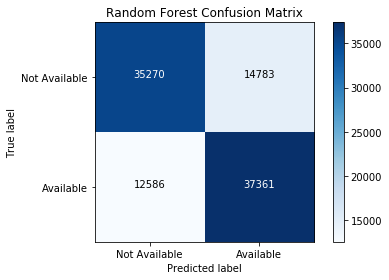

In [131]:
rf_cm = confusion_matrix(y_test, rf_test_preds)
plot_confusion_matrix(rf_cm, ['Not Available', 'Available'], "Random Forest Confusion Matrix")

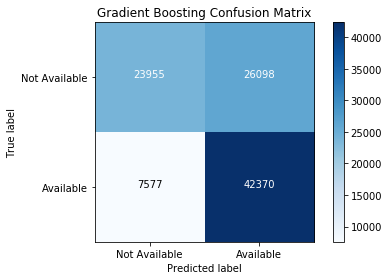

In [210]:
gb_cm = confusion_matrix(y_test, gb_test_preds)
plot_confusion_matrix(gb_cm, ['Not Available', 'Available'], "Gradient Boosting Confusion Matrix")

While the accuracy between the two algorithms is not that different, the pattern of prediction between the two is very different. For the Random Forest algorithm, it achieves its accuracy by correctly predicting approximiately 3/4 of the available and not available listings. 

For the Gradient Boosted algorithm, it does an excellent job at predicting those that are available, but for those that are not available, it is currently 50/50.

<a id="initial_curve"></a>
#### 8.1.4 Learning curve

Let's also have a look at the learning curves for each algorithm, adapted from [scikit learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html).

In [133]:
def plot_learning_curve(clf, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5), show_ci=False):
    '''
    Plots learning curve for a classifier.
    
    Arguments:
        clf: Classifier object.
        X: Features array.
        y: Response array.
        cv: Cross-validation details. Defined by requirements for sklearn's learning curve function.
        n_jobs: (int) Number of cores to use to complete (-1 is all).
        train_sizes: Array of splits for training.
        show_ci: (bool) Indicates if 1 std of shading is shown for confidence interval.
    '''
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    plt.plot(train_sizes, train_scores_mean, color="#1f77b4", label="Training score")
    plt.plot(train_sizes, test_scores_mean, color="#da8025", label="Cross-validation score")
    if show_ci:
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std, 
                         train_scores_mean + train_scores_std, alpha=0.1, color="#1f77b4")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std, 
                         test_scores_mean + test_scores_std, alpha=0.1, color="#da8025")
    plt.legend(loc="best")
    plt.xlabel("Number of training examples")
    plt.ylabel("Score")
    plt.ylim(ymax=1.1, ymin=0)
    plt.title("{} Learning Curve".format(clf.named_steps['clf'].__class__.__name__))
    plt.show()

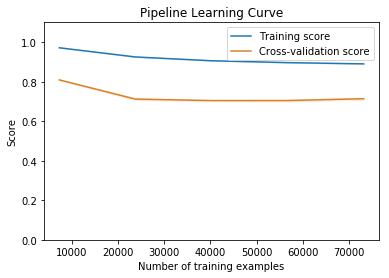

In [211]:
plot_learning_curve(rf_pipeline, X_train_initial, y_train, n_jobs=3, cv=5, show_ci=True)

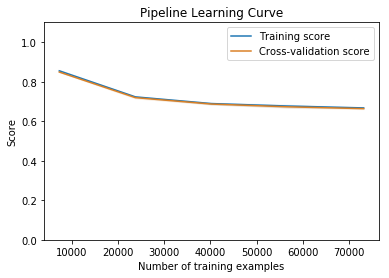

In [212]:
plot_learning_curve(gb_pipeline, X_train_initial, y_train, n_jobs=3, cv=5, show_ci=True)

Hmm, rather than overfitting, it seems that for both models, the issue is underfitting, rather than overfitting. This does make sense given that we included quite a limited set of features for the model.

<a id="initial_feat_import"></a>
#### 8.1.6 Feature importance

Let's have a look at which features contributed the most to our predictions. This plot is adapted from [scikit-learn's documentation](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html).

In [207]:
def plot_feature_importance(clf, keep_cols, fig_size=(5, 6)):
    classifier = clf.named_steps['clf']
    importances = classifier.feature_importances_
    indices = np.argsort(importances)
    features = np.array([col for col in keep_cols if col != 'id'])
    features = features[indices]
    
    # Plot the feature importances of the forest
    plt.figure(figsize=fig_size)
    plt.title("Feature Importances for {}".format(classifier.__class__.__name__))
    plt.barh(range(features.shape[0]), importances[indices], align="center")
    plt.yticks(range(features.shape[0]), features)
    plt.ylim([-1, features.shape[0]]);
    
    # Print the feature ranking
    print("Feature Ranking %s:" % (classifier.__class__.__name__))

    for f in range(features.shape[0]):
        print("%d. %s: %f" % (f + 1, features[::-1][f], importances[indices[::-1][f]]))

Feature Ranking RandomForestClassifier:
1. price: 0.735784
2. accommodates: 0.073388
3. weekday: 0.068689
4. bathrooms: 0.054099
5. bedrooms: 0.035253
6. winter: 0.004445
7. winter_break: 0.003740
8. fall: 0.003493
9. mlk: 0.002456
10. summer_break: 0.002450
11. spring: 0.002369
12. spring_break: 0.002208
13. summer: 0.002021
14. mid_winter_break: 0.001632
15. memorial: 0.001413
16. presidents: 0.001351
17. labor: 0.001184
18. christmas: 0.001053
19. fourth_july: 0.001034
20. veteran: 0.001000
21. thanksgiving: 0.000935
22. new_year: 0.000000


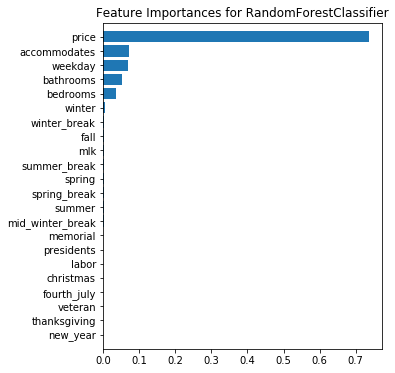

In [208]:
plot_feature_importance(rf_pipeline, keep_cols)

Feature Ranking GradientBoostingClassifier:
1. price: 0.835180
2. bedrooms: 0.043795
3. accommodates: 0.038779
4. bathrooms: 0.030403
5. winter: 0.018155
6. fall: 0.013735
7. winter_break: 0.008559
8. summer_break: 0.006077
9. mlk: 0.004728
10. spring: 0.000353
11. weekday: 0.000161
12. christmas: 0.000075
13. fourth_july: 0.000000
14. memorial: 0.000000
15. presidents: 0.000000
16. spring_break: 0.000000
17. new_year: 0.000000
18. labor: 0.000000
19. veteran: 0.000000
20. summer: 0.000000
21. thanksgiving: 0.000000
22. mid_winter_break: 0.000000


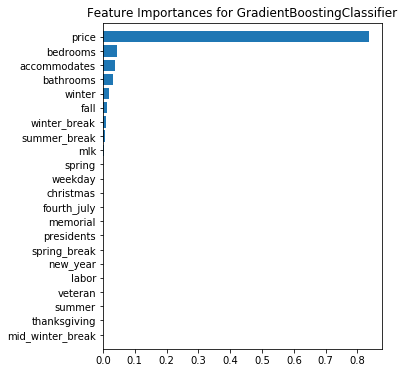

In [209]:
plot_feature_importance(gb_pipeline, keep_cols)

We can see that there are similaritiest in feature importance between the two - `price` is the most important feature for each, and `accommodates`, `bedrooms` and `bathrooms` are also top five features. The largest difference is that the Random Forest classifier places a higher importance on the `weekday` feature than for the Gradient Boosting classifier, where it has very low importance. Also, the Gradient Boosting classifier more quickly places zero importance on features.

<a id="develop"></a>
### 8.2 Model Development

#### 8.2.1 Attempt 1

Based on the above information, it seems that it is possible to remove the date information with limited impact on the model accuracy. The one date information I'll keep is whether the day is a weekday or not. 

Let's also consider what features area available from the AirBnB review page. We could add features about 
- Property/room type
- The number of reviews received by the host
- Whether they are a superhost

It's also worth noting that bathrooms, and the number of people that the listing accommodates are not things that can be seen on the review page, so let's try a model with those also excluded.

In [245]:
keep_cols = ['id', 'price', 'bedrooms', 'weekday', 'host_is_superhost', 
             'number_of_reviews', 'property_type_Apartment',
             'property_type_Bed & Breakfast', 'property_type_Boat',
             'property_type_Bungalow', 'property_type_Cabin',
             'property_type_Camper/RV', 'property_type_Chalet',
             'property_type_Condominium', 'property_type_Dorm',
             'property_type_House', 'property_type_Loft', 'property_type_Other',
             'property_type_Tent', 'property_type_Townhouse',
             'property_type_Treehouse', 'property_type_Yurt', 'property_type_nan',
             'room_type_Entire home/apt', 'room_type_Private room',
             'room_type_Shared room', 'room_type_nan']

dtypes={"price": float, "name": str, 
       "host_since": int, "host_response_time": str, "host_is_superhost": int, 
       "host_has_profile_pic": int, "host_identity_verified": int, 
       "neighbourhood_cleansed": str, "neighbourhood_group_cleansed": str,
       "latitude": float, "longitude": float, 
       "property_type": str, "room_type": str, "accommodates": int, 
       "bathrooms": float, "bedrooms": float, "beds": float, "bed_type": str,
       "security_deposit": float, "cleaning_fee": float, "extra_people": float,
       "number_of_reviews": int, "review_scores_rating": float, 
       "review_scores_accuracy": float, "review_scoares_cleanliness": float,
       "review_scores_checkin": float, "review_scores_communication": float,
       "review_scores_location": float, "review_scores_value": float, 
       "instant_bookable": int, "cancellation_policy": str, 
       "require_guest_profile_picture": int, 
       "require_guest_phone_verification": int}

X_train_develop = read_X_data('data/X_train.csv', dtypes=dtypes, keep_cols=keep_cols)
X_test_develop = read_X_data('data/X_test.csv', dtypes=dtypes, keep_cols=keep_cols, sample=100000)
y_train = read_y_data('data/y_train.csv')
y_test = read_y_data('data/y_test.csv', index=X_test_develop.index)

Since we may be completing this a number of times, let's create a function for assessing the pipeline.

In [310]:
def pipeline_results(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)
    
    # Get training accuracy
    preds_train = pipeline.predict(X_train)
    acc_train = accuracy_score(y_train, preds_train)
    
    # Get test accuracy
    preds_test = pipeline.predict(X_test)
    acc_test = accuracy_score(y_test, preds_test)
    print("{} train acc: {}, test acc: {}".format(
        pipeline.named_steps['clf'].__class__.__name__, acc_train, acc_test))
    
    return pipeline, preds_train, preds_test

In [246]:
# Get results
rf_pipeline, rf_preds_test_develop, rf_preds_test_develop \
= pipeline_results(rf_pipeline, X_train_develop, X_test_develop, y_train, y_test)

gb_pipeline, gb_preds_test_develop, gb_preds_test_develop \
= pipeline_results(gb_pipeline, X_train_develop, X_test_develop, y_train, y_test)

RF Train acc: 0.9193617184167642; GB Train acc: 0.6769656469764745
RF Test acc: 0.8557; GB Test acc: 0.67831


By adding these additional features, we have improved the accuracy of our RF classifier, but had limited improvement with the GB classifier. While it may be possible to find additional improvements for the GB classifier with tuning, I am going to focus on the RF classifier.

Let's have a look at the confusion matrix, learning curve and feature importance again.

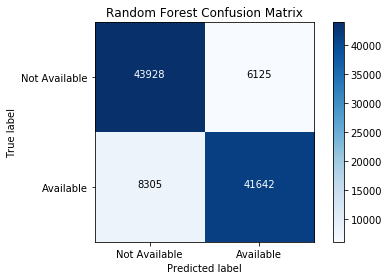

In [247]:
rf_cm_develop = confusion_matrix(y_test, rf_preds_test_develop)
plot_confusion_matrix(rf_cm_develop, ['Not Available', 'Available'], 
                      "Random Forest Confusion Matrix")

Looks like our accuracy has been improved by correctly assigning more of the listings for both "Available" and "Not Available".

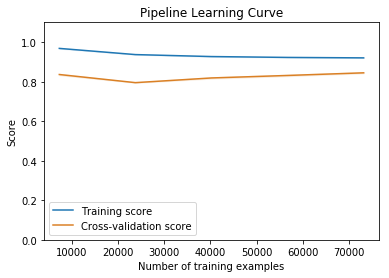

In [248]:
plot_learning_curve(rf_pipeline, X_train_develop, y_train, n_jobs=3, cv=5, show_ci=True)

We are still underfitting the data to some extent, though it has improved.

Feature Ranking RandomForestClassifier:
1. price: 0.602997
2. number_of_reviews: 0.235767
3. weekday: 0.059377
4. bedrooms: 0.035538
5. host_is_superhost: 0.012919
6. property_type_House: 0.009410
7. property_type_Apartment: 0.008431
8. room_type_Entire home/apt: 0.006136
9. room_type_Private room: 0.005830
10. room_type_Shared room: 0.004305
11. property_type_Condominium: 0.004189
12. property_type_Townhouse: 0.003313
13. property_type_Loft: 0.002233
14. property_type_Other: 0.001802
15. property_type_Bed & Breakfast: 0.001403
16. property_type_Cabin: 0.001298
17. property_type_Bungalow: 0.001257
18. property_type_Camper/RV: 0.001203
19. property_type_Boat: 0.000800
20. property_type_Tent: 0.000770
21. property_type_Treehouse: 0.000512
22. property_type_Dorm: 0.000233
23. property_type_Yurt: 0.000131
24. property_type_nan: 0.000122
25. property_type_Chalet: 0.000026
26. room_type_nan: 0.000000


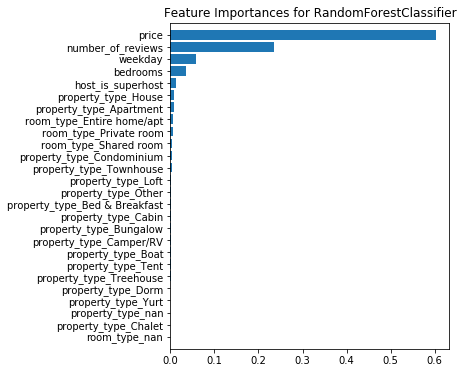

In [249]:
plot_feature_importance(rf_pipeline, keep_cols)

Interesting - when the number of reviews is included, the relative contribution of price decreases. If we only included `price`, `number_of_review`, `weekday`, `bedrooms`, and `host_is_superhost` in our predictions, we'd still capture the majority what is captured here in our prediction.

#### 8.2.2 Attempt 2

Let's retain the features that contribute at least 0.1% to the accuracy, so from `property_type_Camper/RV` upwards.

There are two features that are available in the initial view that are not included in this model - the cancellation policy and the name of the property. If we include these features, how do they impact the accuracy of the model?

We'll need to create a different pipeline to include the processing of the property name.

In [308]:
rf_pipeline_wordcount = Pipeline([
    ('skew', SkewCorrection()),
    ('price', FillByID(id_column='id', fill_column='price', drop_id=True)),
    ('wordcount', WordCount(column='name')),
    ('clf', RandomForestClassifier(random_state=42))
])

In [330]:
keep_cols = ['id', 'price', 'bedrooms', 'weekday', 'host_is_superhost', 
             'number_of_reviews', 'property_type_Apartment',
             'property_type_Bed & Breakfast', 'property_type_Bungalow', 
             'property_type_Cabin', 'property_type_Camper/RV', 
             'property_type_Condominium', 'property_type_House', 
             'property_type_Loft', 'property_type_Other', 
             'property_type_Townhouse', 'room_type_Entire home/apt', 
             'room_type_Private room', 'room_type_Shared room', 'name', 
             'cancellation_policy_flexible', 'cancellation_policy_moderate', 
             'cancellation_policy_strict', 'cancellation_policy_nan']

dtypes={"price": float, "name": str, 
       "host_since": int, "host_response_time": str, "host_is_superhost": int, 
       "host_has_profile_pic": int, "host_identity_verified": int, 
       "neighbourhood_cleansed": str, "neighbourhood_group_cleansed": str,
       "latitude": float, "longitude": float, 
       "property_type": str, "room_type": str, "accommodates": int, 
       "bathrooms": float, "bedrooms": float, "beds": float, "bed_type": str,
       "security_deposit": float, "cleaning_fee": float, "extra_people": float,
       "number_of_reviews": int, "review_scores_rating": float, 
       "review_scores_accuracy": float, "review_scoares_cleanliness": float,
       "review_scores_checkin": float, "review_scores_communication": float,
       "review_scores_location": float, "review_scores_value": float, 
       "instant_bookable": int, "cancellation_policy": str, 
       "require_guest_profile_picture": int, 
       "require_guest_phone_verification": int}

X_train_develop2 = read_X_data('data/X_train.csv', dtypes=dtypes, keep_cols=keep_cols)
X_test_develop2 = read_X_data('data/X_test.csv', dtypes=dtypes, keep_cols=keep_cols, sample=100000)
y_train_develop2 = read_y_data('data/y_train.csv')
y_test_develop2 = read_y_data('data/y_test.csv', index=X_test_develop.index)

In [309]:
rf_pipeline_wordcount, rf_train_preds_develop2, rf_test_preds_develop2 \
= pipeline_results(rf_pipeline_wordcount, X_train_develop2, X_test_develop2, y_train_develop2, y_test_develop2)

C:\Users\rebecca-barnes\Anaconda3\envs\dand\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier train accuracy: 0.9406122515940634


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [121]:
rf_pipeline.named_steps['clf'].estimators_

[DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=462038387, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False,
             random_state=484303475, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
             max_features='auto', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weig

All models reached conversion (or close to). When looking at speed and performance, the best seemed to be the GradientBoosting Classifier.

Let's have a look at the f-score and roc-auc score for each classifer.

In [107]:
def train_predict(clf, X_train, y_train, X_test, y_test): 
    '''
    Arguments:
       clf: Learning algorithm to be trained and predicted on.
       X_train: Features training set.
       y_train: Response training set.
       X_test: Features testing set
       y_test: Response testing set.
    '''
    results = {}
    
    # Fit and predict
    clf.fit(X_train, y_train)
    train_preds = clf.predict(X_train)
    test_preds = clf.predict(X_test)
    
    # Get scores
    results["f_train"] = f1_score(y_train, train_preds)
    results["f_test"] = f1_score(y_test, test_preds)
    results["roc_train"] = roc_auc_score(y_train, train_preds)
    results["roc_test"] = roc_auc_score(y_test, test_preds)
        
    # Return the results
    return results

In [182]:
# Limit validation to 5000
X_scores_valid = X_valid_scaled[:5000]
y_scores_valid = y_valid[:5000]

# Collect scores
scores = {}
for clf in [clf_rf, clf_gb, clf_svc]:
    clf_name = clf.__class__.__name__
    scores[clf_name] = train_predict(clf, X_lc, y_lc, X_scores_valid, y_scores_valid)

In [183]:
cols = ["f_train", "f_test", "roc_train", "roc_test"]
pd.DataFrame(scores).transpose()[cols]

,f_train,f_test,roc_train,roc_test
GradientBoostingClassifier,1.000000,0.066887,1.000000,0.500377
RandomForestClassifier,0.999799,0.096646,0.999800,0.506996
SVC,0.999399,0.139895,0.999401,0.518346


We can see that there is a large amount of overfitting for each model at this time, which is not that suprising given that the default settings have been used. While SVC has a longer calculation time, it performed the best on each metric.

Just to see what is being predicted, it might be worth looking at a confusion matrix. (Plotting resource from [sci-kit learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)

At the moment, all of the algorithms are predicting most entries as "Not Available". This means that the correct predictions are primarily listings that are not available that are listed as such. 

Given the much longer training times for SVC. I'm going to stick with tuning the GB classifier for a balance between performance and time to train/tune. 

<a id="tuning"></a>
### 7.3. Model Tuning

It is suggested that Random Searching can find optimal parameters more efficiently than grid searching ([Reference](https://www.analyticsindiamag.com/why-is-random-search-better-than-grid-search-for-machine-learning/)). As a result, I'll be performing a random search on hyperparameters for both Random Forest and Gradient Boosting classifiers. [Sci-kit learn documentation](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html#sphx-glr-auto-examples-model-selection-plot-randomized-search-py) was consulted to implement the random search.

I consulted a number of other resources to develop my work in this area:
- [Introduction: Hyperparameter Tuning using Grid and Random Search](https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search)
- [Complete Guide to Parameter Tuning in Gradient Boosting (GBM) in Python](https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/)
- Sci-kit learn documentation: [Early stopping of Gradient Boosting](https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html)

In [187]:
# Read in data
#X_train = pd.read_csv("data/X_train_scaled.csv").values
#y_train = pd.read_csv("data/y_train.csv", header=None).values.ravel()

# Instantiate model
clf_gb = GradientBoostingClassifier(n_estimators=1000, tol=0.01, 
                                    subsample=0.8, n_iter_no_change=25, 
                                    random_state=42)

# Define param distributions
param_dist_gb = {"learning_rate": np.logspace(np.log10(0.005), np.log10(0.5), 
                                              base=10, num=1000), 
                 "max_depth": sp_randint(2, 25),
                 "min_samples_split": sp_randint(500, 5000), 
                 "min_samples_leaf": sp_randint(500, 10000), 
                 "max_features": sp_randint(2, int(266*0.4)),
                 "max_leaf_nodes": sp_randint(2, 50)}

In [192]:
# Make scorers
scorer_f = make_scorer(f1_score)
scorer_roc = make_scorer(roc_auc_score)

# Create random search objects
random_search_f = RandomizedSearchCV(clf_gb, param_dist_gb, n_iter=25, 
                                     scoring=scorer_f, n_jobs=3, cv=5, 
                                     random_state=42, verbose=10)
random_search_roc = RandomizedSearchCV(clf_gb, param_dist_gb, n_iter=25, 
                                       scoring=scorer_roc, n_jobs=3, cv=5, 
                                       random_state=42, verbose=10)

In [193]:
# Fit f-score
random_search_f.fit(X_train_scaled, y_train)
best_clf_f = random_search_f.best_estimator_

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed:  3.3min
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 12.9min
[Parallel(n_jobs=3)]: Done  12 tasks      | elapsed: 15.7min
[Parallel(n_jobs=3)]: Done  19 tasks      | elapsed: 19.5min
[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed: 21.7min
[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed: 23.9min
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed: 25.8min
[Parallel(n_jobs=3)]: Done  55 tasks      | elapsed: 42.3min
[Parallel(n_jobs=3)]: Done  66 tasks      | elapsed: 46.6min
[Parallel(n_jobs=3)]: Done  79 tasks      | elapsed: 51.7min
[Parallel(n_jobs=3)]: Done  92 tasks      | elapsed: 54.6min
[Parallel(n_jobs=3)]: Done 107 tasks      | elapsed: 65.8min
[Parallel(n_jobs=3)]: Done 125 out of 125 | elapsed: 72.5min finished


In [194]:
best_f_preds = best_clf_f.predict(X_valid_scaled)
best_f_score = f1_score(y_valid, best_f_preds)
best_f_score

0.06275944493609102

In [196]:
best_clf_f.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.0080015515686935, loss='deviance',
              max_depth=21, max_features=94, max_leaf_nodes=16,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=5691, min_samples_split=4272,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              n_iter_no_change=25, presort='auto', random_state=42,
              subsample=0.8, tol=0.01, validation_fraction=0.1, verbose=0,
              warm_start=False)>